# Online Retail II - Commercial Customer Analytics

Objective:   
This notebook converts transaction data into decisions for growth and retention. The focus is not only descriptive EDA, but also customer-value diagnostics that a business team can act on.

Table of Contents
1. Data quality and preprocessing
2. Exploratory data analysis (revenue, demand timing, cancellations, products, countries)
3. Customer intelligence models (RFM, cohort retention, CLV, repeat, churn)
4. Final conclusion and action plan

Business Questions Answered  

1. How are revenue, order value, and seasonality evolving over time?
2. Where are cancellations concentrated, and are they scale-driven or risk-driven?
3. Which products, customers, and countries drive volume and revenue concentration?
4. What does customer quality look like across RFM, retention cohorts, and CLV tiers?
5. How large is repeat behavior, and how sensitive is churn to the inactivity threshold?

Dataset Snapshot  

- Source: UCI Online Retail II
- Period covered: December 2009 to December 2011
- Entity: UK-based non-store online retailer
- Key fields: `Invoice`, `Description`, `Quantity`, `InvoiceDate`, `Price`, `Customer ID`, `Country`

KPI Definitions Used  

- Revenue: `Quantity * Price` at line level
- Order: unique invoice count
- Cancellation: invoice starts with `C` or negative quantity lines
- AOV: `Revenue / Orders`
- Churn proxy: no purchase for at least 90 days (with threshold sensitivity test)


In [52]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import textwrap

# Date & Time
from datetime import datetime, timedelta

# Statistics
from scipy import stats

# Machine Learning (for RFM Segmentation)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Warnings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# Global plotting theme (consistent, high-contrast, presentation-safe)
sns.set_theme(style='whitegrid', context='notebook', palette='colorblind')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.dpi': 120,
    'figure.facecolor': 'white',
    'figure.autolayout': False,
    'axes.facecolor': '#f9fafb',
    'axes.edgecolor': '#4b5563',
    'axes.labelcolor': '#111827',
    'axes.titlesize': 13,
    'axes.titleweight': 'bold',
    'axes.labelsize': 11,
    'xtick.color': '#111827',
    'ytick.color': '#111827',
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'grid.color': '#9ca3af',
    'grid.linestyle': '--',
    'grid.alpha': 0.35,
    'legend.frameon': True,
    'legend.facecolor': 'white',
    'legend.edgecolor': '#d1d5db'
})


def format_gbp(value, decimals=0):
    if pd.isna(value):
        return 'NA'
    fmt = '{:,.%df}' % decimals
    return 'GBP ' + fmt.format(value)


In [53]:
df = pd.read_csv(r"C:\Eni data\PYTHON\PYTHON CODES & PROJECTS\Datasets\online_retail_II.csv")
df.sample(10)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
857284,566039,23245,SET OF 3 REGENCY CAKE TINS,4,2011-09-08 13:38:00,4.95,14223.0,United Kingdom
779098,559163,47574A,ENGLISH ROSE SCENTED HANGING FLOWER,2,2011-07-06 16:33:00,2.46,NaN,United Kingdom
505728,536592,22692,DOORMAT WELCOME TO OUR HOME,1,2010-12-01 17:06:00,7.95,NaN,United Kingdom
761731,557745,23310,BUBBLEGUM RING ASSORTED,36,2011-06-22 12:16:00,0.42,15750.0,United Kingdom
182942,506740,M,Manual,1,2010-05-04 10:31:00,269.34,14911.0,EIRE
577373,540681,21618,4 WILDFLOWER BOTANICAL CANDLES,1,2011-01-10 16:25:00,2.51,NaN,United Kingdom
788585,559937,48187,DOORMAT NEW ENGLAND,2,2011-07-14 10:11:00,7.95,13577.0,United Kingdom
417938,529325,22315,200 RED + WHITE BENDY STRAWS,1,2010-10-27 14:10:00,2.51,NaN,United Kingdom
745991,556198,22557,PLASTERS IN TIN VINTAGE PAISLEY,1,2011-06-09 12:30:00,1.65,14963.0,United Kingdom
992641,576339,22619,SET OF 6 SOLDIER SKITTLES,2,2011-11-14 15:27:00,7.46,14096.0,United Kingdom


In [54]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [55]:
df.dtypes

Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
dtype: object

In [56]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

In [57]:
summary = (
    pd.DataFrame({
        'dtype': df.dtypes,
        'non_null': df.notna().sum(),
        'nulls': df.isna().sum(),
        'null_%': (df.isna().mean() * 100).round(2),
        'unique': df.nunique()
    })
    .sort_values('null_%', ascending=False)
)

duplicate_rows = df.duplicated().sum()
quality_snapshot = pd.DataFrame({
    'Metric': [
        'Total Rows',
        'Duplicate Rows',
        'Duplicate Row %',
        'Rows with null Description %',
        'Rows with null Customer ID %',
        'Rows with invalid InvoiceDate %',
        'Rows with non-positive Price %',
        'Rows with negative Quantity %'
    ],
    'Value': [
        len(df),
        duplicate_rows,
        round(100 * duplicate_rows / len(df), 2),
        round(100 * df['Description'].isna().mean(), 2),
        round(100 * df['Customer ID'].isna().mean(), 2),
        round(100 * df['InvoiceDate'].isna().mean(), 2),
        round(100 * (df['Price'] <= 0).mean(), 2),
        round(100 * (df['Quantity'] < 0).mean(), 2)
    ]
})

print('Column-Level Data Quality Summary')
display(summary)
print()
print('Dataset-Level Data Quality Snapshot')
display(quality_snapshot)


Column-Level Data Quality Summary


,dtype,non_null,nulls,null_%,unique
Customer ID,float64,824364,243007,22.77,5942
Description,object,1062989,4382,0.41,5698
StockCode,object,1067371,0,0.00,5305
Invoice,object,1067371,0,0.00,53628
Quantity,int64,1067371,0,0.00,1057
InvoiceDate,datetime64[ns],1067371,0,0.00,47635
Price,float64,1067371,0,0.00,2807
Country,object,1067371,0,0.00,43



Dataset-Level Data Quality Snapshot


,Metric,Value
0,Total Rows,1067371.00
1,Duplicate Rows,34335.00
2,Duplicate Row %,3.22
3,Rows with null Description %,0.41
4,Rows with null Customer ID %,22.77
5,Rows with invalid InvoiceDate %,0.00
6,Rows with non-positive Price %,0.58
7,Rows with negative Quantity %,2.15


## Cleaning and Preprocessing

### Rules applied
- Drop rows with missing `Description` because product-level analysis is not possible without it.
- Keep two working tables:
  - `df_sales`: all rows (guests included) for overall commercial trends.
  - `df_customer`: known `Customer ID` rows only for customer-level modeling.
- Build reusable fields:
  - `Is_Cancellation` to standardize return/cancel logic.
  - `LineRevenue` for consistent monetary calculations across sections.

### Why this matters
This separation avoids mixing guest and identified customers in CLV/RFM/churn while preserving full sales behavior for business-level trend analysis.


In [58]:
# Remove missing product description rows (small share and unusable for product analysis)
df = df.dropna(subset=['Description']).copy()

# Remove duplicated rows
df = df.drop_duplicates()

# Standardize base fields used across sections
df['Invoice'] = df['Invoice'].astype(str).str.strip()
df['Is_Cancellation'] = df['Invoice'].str.startswith('C') | (df['Quantity'] < 0)
df['LineRevenue'] = df['Quantity'] * df['Price']

# Customer-level dataset (only known customers)
df_customer = df.dropna(subset=['Customer ID']).copy()
df_customer['Customer ID'] = df_customer['Customer ID'].astype('Int64')

# Sales-level dataset (keep all rows, fill guest)
df_sales = df.copy()
df_sales['Customer ID'] = df_sales['Customer ID'].astype('string').fillna('Guest')


print(f"df_sales shape   : {df_sales.shape}")
print(f"df_customer shape: {df_customer.shape}")
print(f"Cancellation rows: {df_sales['Is_Cancellation'].sum():,} ({100 * df_sales['Is_Cancellation'].mean():.2f}%)")



df_sales shape   : (1028761, 10)
df_customer shape: (797885, 10)
Cancellation rows: 19,864 (1.93%)


---
## Exploratory Data Analysis
---
#### Core EDA: Revenue, Demand Timing, Cancellations, Products, Countries

Each subsection follows the same pattern: question -> evidence -> practical implication.


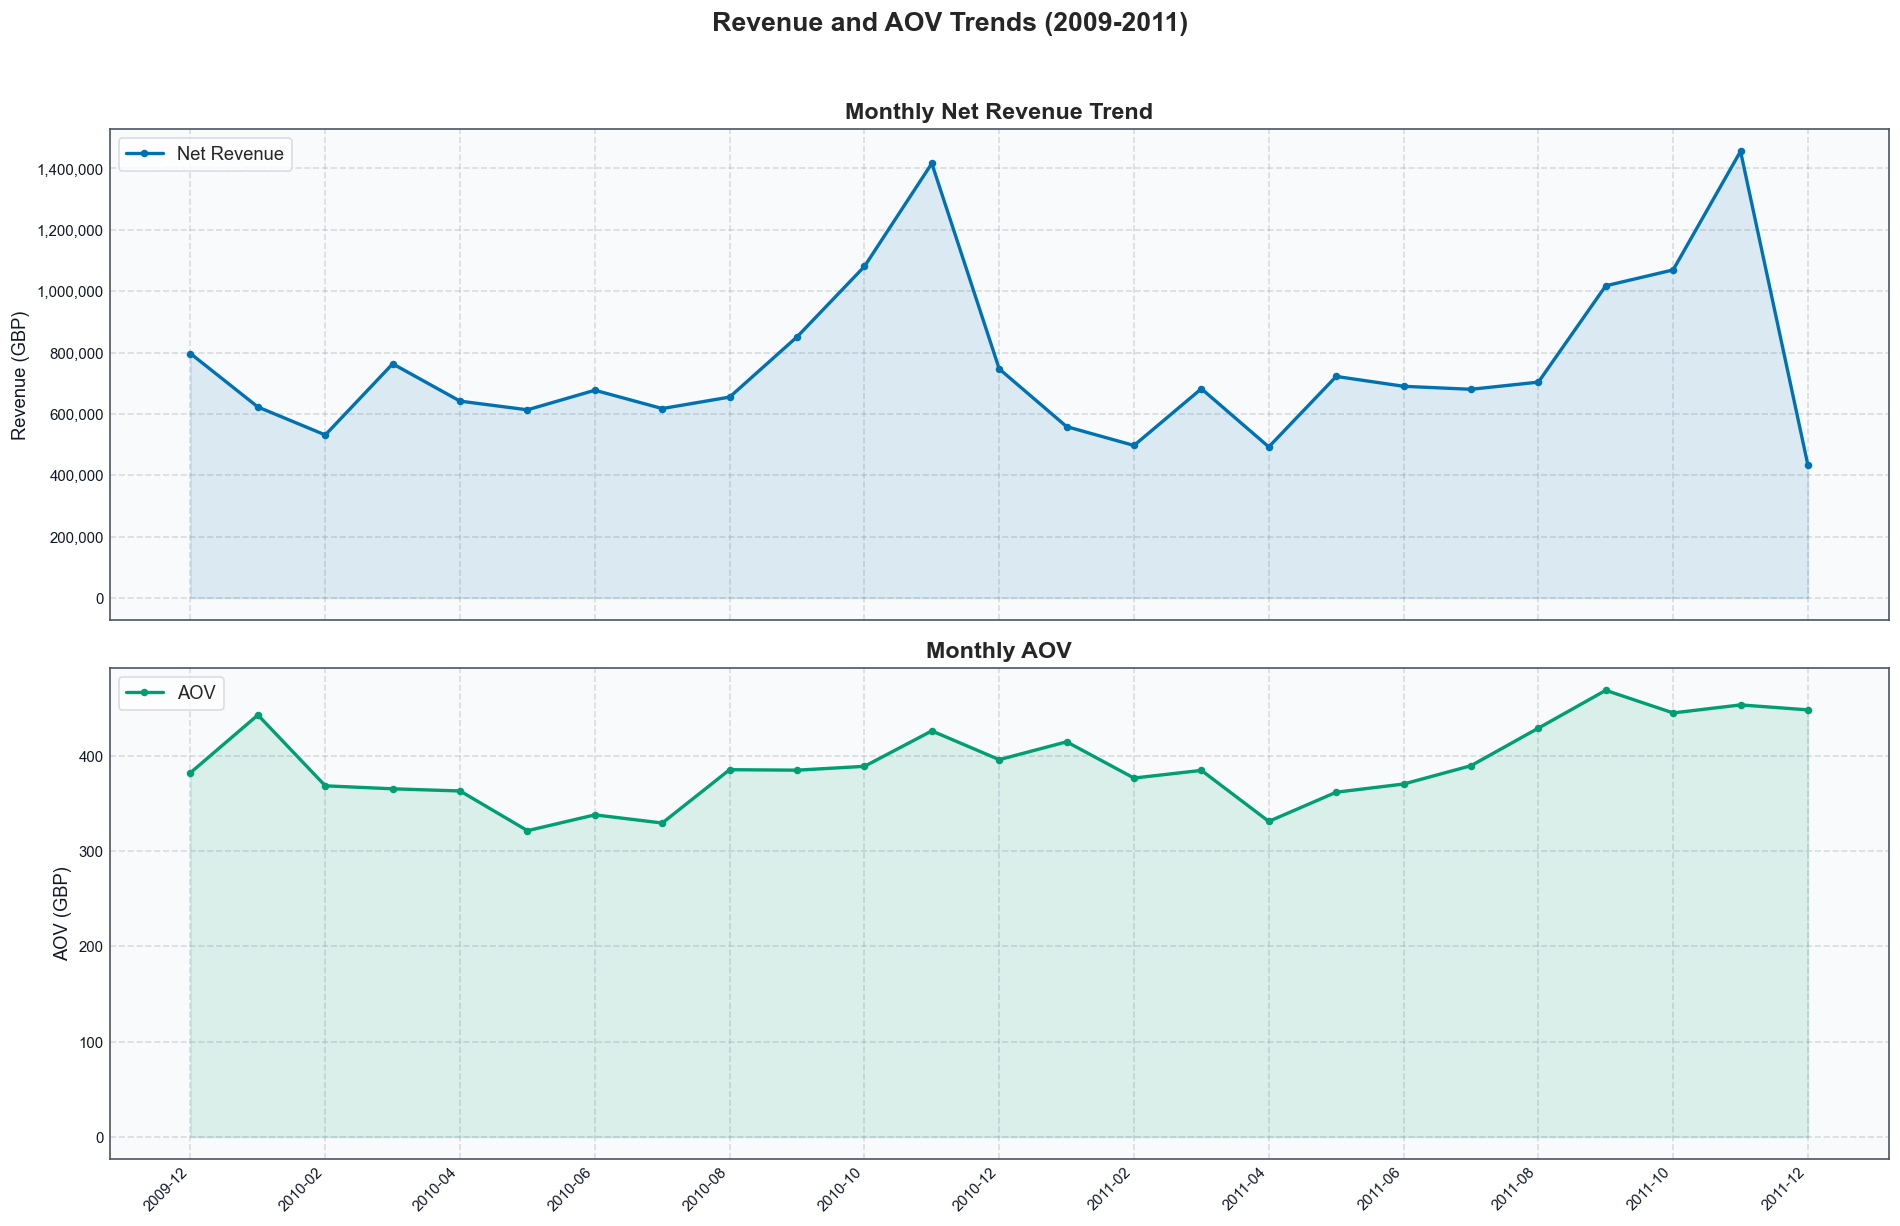

Peak Revenue Month : 2011-11 (GBP 1,456,146)
Avg Monthly Revenue: GBP 760,568
Avg AOV            : GBP 390.81


In [59]:
# ============================================================
# Monthly Revenue Trend and Average Order Value (AOV)
# ============================================================
df_sales['InvoiceDate'] = pd.to_datetime(df_sales['InvoiceDate'])
df_sales['YearMonth'] = df_sales['InvoiceDate'].dt.to_period('M')


monthly = df_sales[df_sales['Price'] > 0].groupby('YearMonth').agg(
    Net_Revenue   = ('LineRevenue', 'sum'),       # cancellations auto net off
    Total_Orders  = ('Invoice', 'nunique'),
    Total_Customers = ('Customer ID', 'nunique')
).reset_index()

monthly['AOV']           = monthly['Net_Revenue'] / monthly['Total_Orders']
monthly['YearMonth_str'] = monthly['YearMonth'].astype(str)
x = np.arange(len(monthly))

fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

axes[0].plot(x, monthly['Net_Revenue'], color='#0072B2', linewidth=2, marker='o', markersize=3.5, label='Net Revenue')

axes[0].fill_between(x, monthly['Net_Revenue'], alpha=0.12, color='#0072B2')
axes[0].set_title('Monthly Net Revenue Trend', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Revenue (GBP)')
axes[0].yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
axes[0].legend()
axes[0].grid(True)

axes[1].plot(x, monthly['AOV'], color='#009E73', linewidth=2, marker='o', markersize=3.5, label='AOV')
axes[1].fill_between(x, monthly['AOV'], alpha=0.12, color='#009E73')
axes[1].set_title('Monthly AOV', fontsize=14, fontweight='bold')
axes[1].set_ylabel('AOV (GBP)')
axes[1].set_xticks(x[::2])
axes[1].set_xticklabels(monthly['YearMonth_str'].iloc[::2], rotation=45, ha='right')
axes[1].yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
axes[1].legend()
axes[1].grid(True)

plt.suptitle('Revenue and AOV Trends (2009-2011)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

peak = monthly.loc[monthly['Net_Revenue'].idxmax()]
print(f"Peak Revenue Month : {peak['YearMonth_str']} (GBP {peak['Net_Revenue']:,.0f})")
print(f"Avg Monthly Revenue: GBP {monthly['Net_Revenue'].mean():,.0f}")
print(f"Avg AOV            : GBP {monthly['AOV'].mean():,.2f}")

### Time-of-Day and Day-of-Week Analysis

Goal: identify operational demand windows (peak hours, peak days, weekend/weekday mix) for campaign timing and staffing decisions.


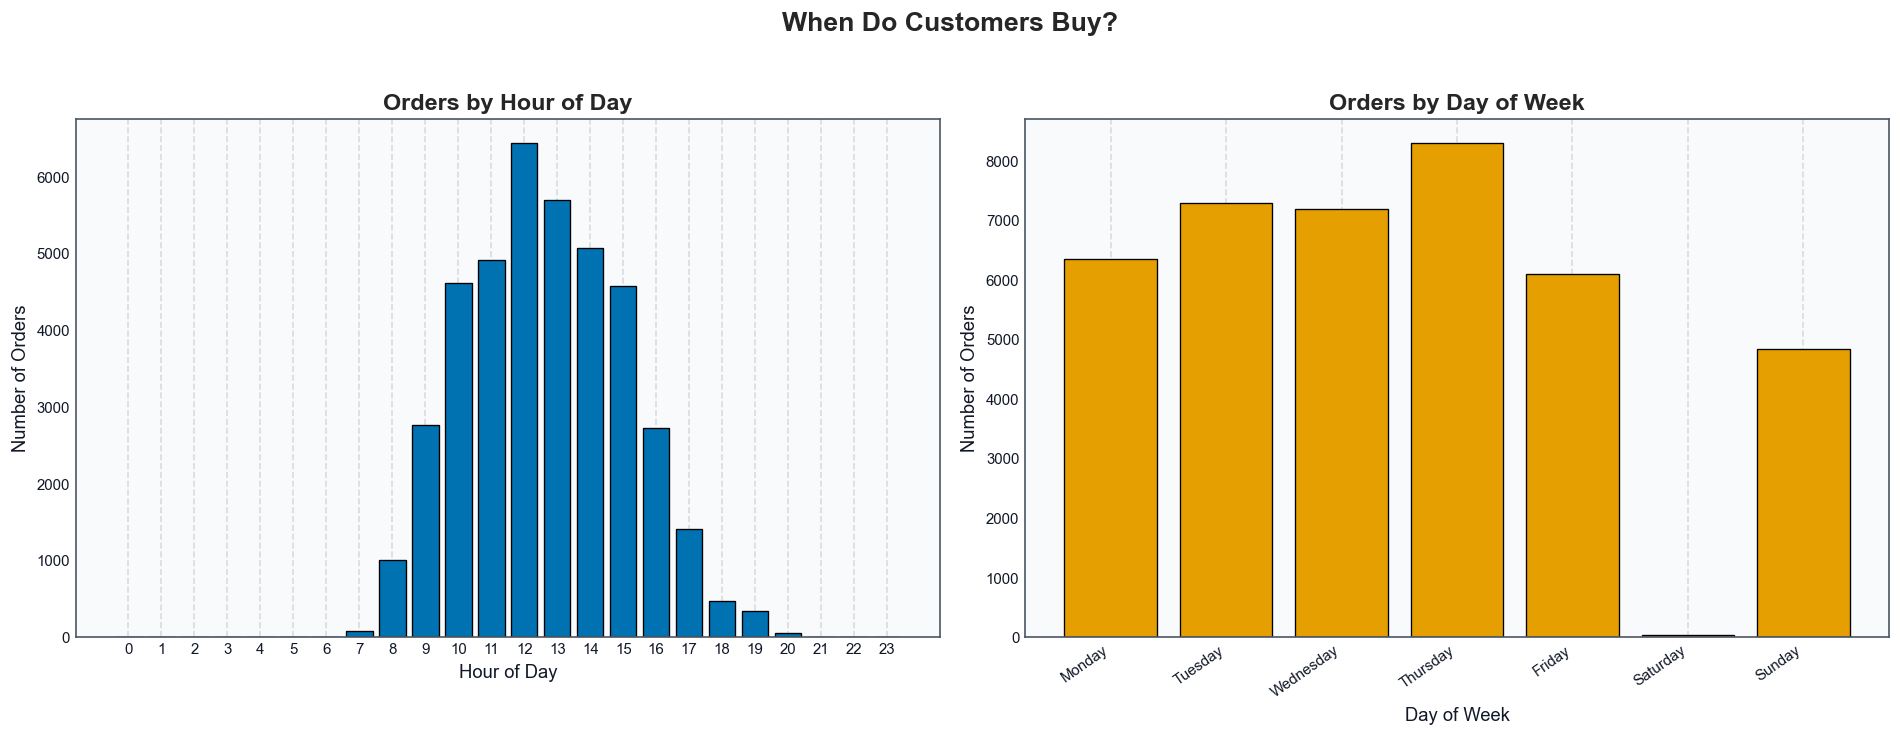

In [60]:
# ============================================================
# Time-of-Day and Day-of-Week Analysis
# ============================================================
df_pos = df_sales[(df_sales['Quantity'] > 0) & (df_sales['Price'] > 0)].copy()
df_pos['Hour'] = df_pos['InvoiceDate'].dt.hour
df_pos['DayOfWeek'] = df_pos['InvoiceDate'].dt.day_name()

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

hourly = (df_pos.groupby('Hour')['Invoice']
          .nunique()
          .reindex(range(24), fill_value=0)
          .reset_index(name='Orders'))

daily = (df_pos.groupby('DayOfWeek')['Invoice']
         .nunique()
         .reindex(day_order)
         .reset_index(name='Orders'))

df_pos['IsWeekend'] = df_pos['DayOfWeek'].isin(['Saturday', 'Sunday'])
week_mix = (df_pos.groupby('IsWeekend')['Invoice']
            .nunique()
            .rename(index={False: 'Weekday', True: 'Weekend'})
            .reset_index(name='Orders'))
week_mix['Order_Share_%'] = 100 * week_mix['Orders'] / week_mix['Orders'].sum()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Orders by Hour
axes[0].bar(hourly['Hour'], hourly['Orders'], color='#0072B2', edgecolor='black', linewidth=0.8)
axes[0].set_title('Orders by Hour of Day', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Number of Orders')
axes[0].set_xticks(range(0, 24, 1))
axes[0].grid(axis='y')

# Orders by Day of Week
axes[1].bar(daily['DayOfWeek'], daily['Orders'], color='#E69F00', edgecolor='black', linewidth=0.8)
axes[1].set_title('Orders by Day of Week', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Number of Orders')
axes[1].tick_params(axis='x', rotation=35)
for lbl in axes[1].get_xticklabels():
    lbl.set_ha('right')
axes[1].grid(axis='y')

plt.suptitle('When Do Customers Buy?', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()




### Cancellations Analysis

Goal: measure cancellation behavior by month and year, then separate normal seasonality from structural risk.


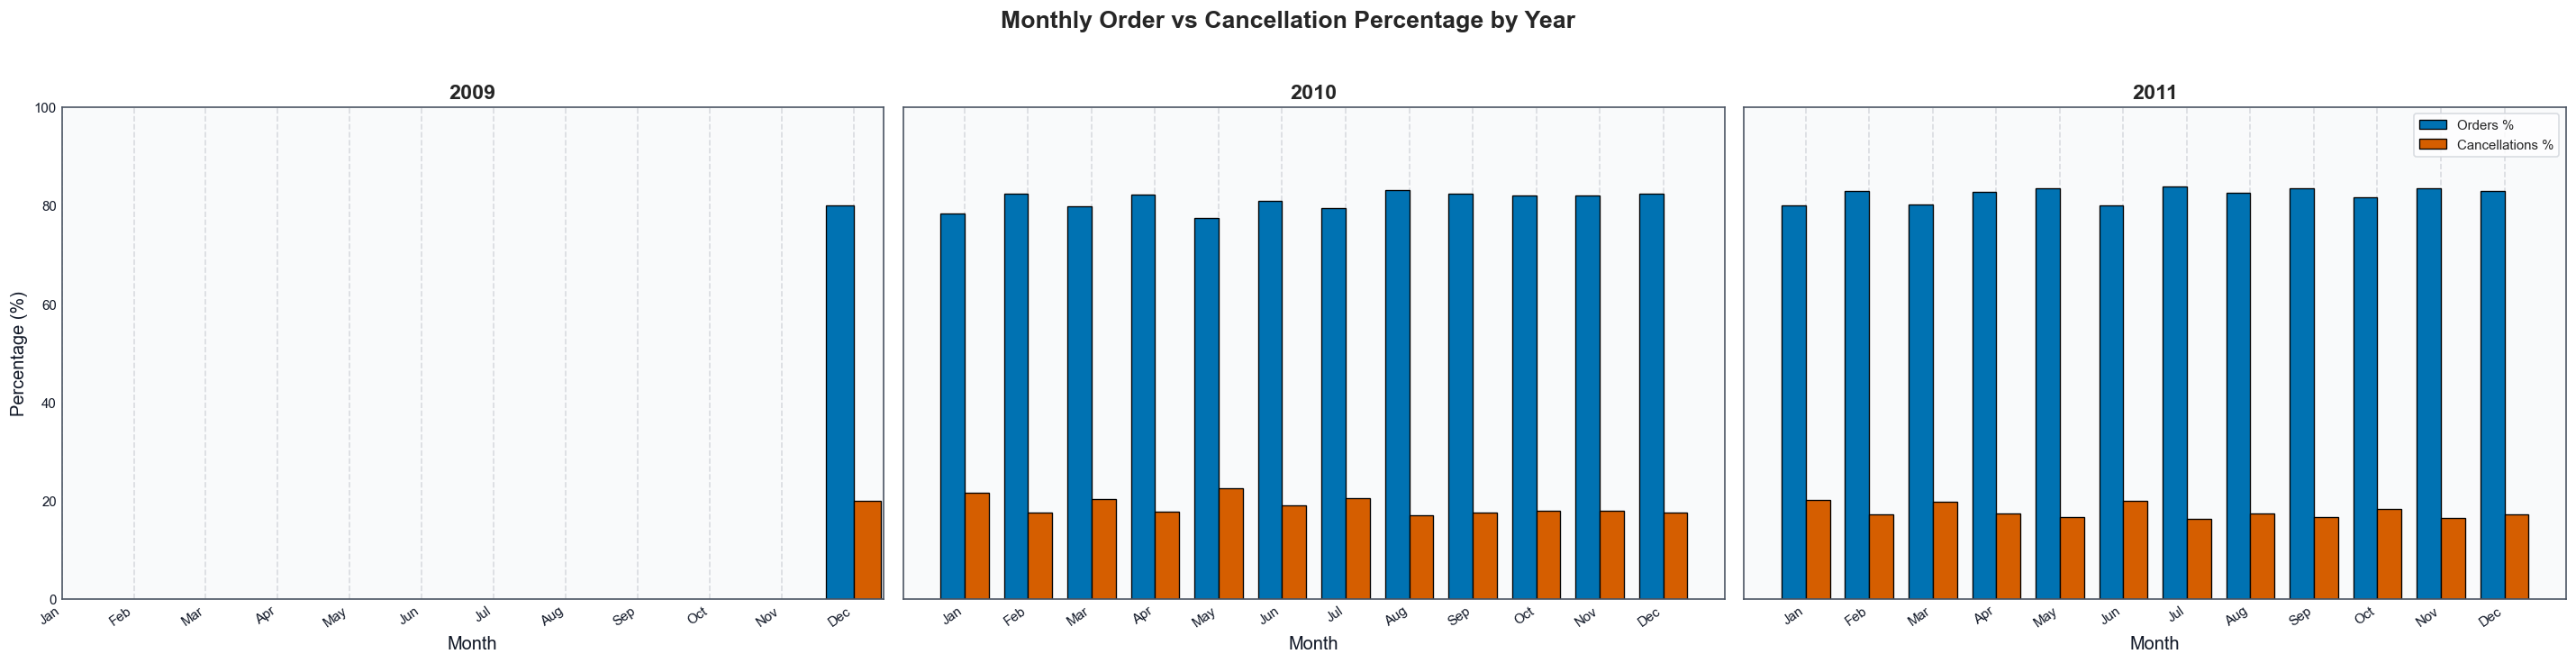

Annual Cancellation Summary (Invoice-Level)


,Year,Orders,Cancellations,Cancellation_Rate_%
0,2009,1682,420,19.98
1,2010,20049,4656,18.85
2,2011,18570,3976,17.64


Highest Monthly Cancellation Rate: 22.55% in 2010-05


In [61]:
# Extract Year and Month from InvoiceDate
df_sales['Year'] = df_sales['InvoiceDate'].dt.year
df_sales['Month'] = df_sales['InvoiceDate'].dt.month

# Separate cancellations and orders at invoice level
df_cancel = (df_sales[df_sales['Is_Cancellation']]
             .groupby(['Year', 'Month'])['Invoice']
             .nunique()
             .reset_index(name='Cancellations'))

df_orders = (df_sales[~df_sales['Is_Cancellation']]
             .groupby(['Year', 'Month'])['Invoice']
             .nunique()
             .reset_index(name='Orders'))

monthly = pd.merge(df_orders, df_cancel, on=['Year', 'Month'], how='left').fillna(0)
monthly['Total'] = monthly['Orders'] + monthly['Cancellations']
monthly['Order_%'] = (monthly['Orders'] / monthly['Total']) * 100
monthly['Cancel_%'] = (monthly['Cancellations'] / monthly['Total']) * 100

# Plot
years = sorted(monthly['Year'].dropna().unique())
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, axes = plt.subplots(1, len(years), figsize=(8 * len(years), 6), sharey=True, squeeze=False)
axes = axes.ravel()
bar_width = 0.38

for i, year in enumerate(years):
    data = monthly[monthly['Year'] == year].sort_values('Month')
    x = data['Month'].values

    axes[i].bar(x - bar_width / 2, data['Order_%'], width=bar_width,
                label='Orders %', color='#0072B2', edgecolor='black', linewidth=0.8)
    axes[i].bar(x + bar_width / 2, data['Cancel_%'], width=bar_width,
                label='Cancellations %', color='#D55E00', edgecolor='black', linewidth=0.8)

    axes[i].set_title(f'{int(year)}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Month', fontsize=12)
    axes[i].set_ylabel('Percentage (%)' if i == 0 else '', fontsize=12)
    axes[i].set_xticks(range(1, 13))
    axes[i].set_xticklabels(month_labels, rotation=35, ha='right')
    axes[i].set_ylim(0, 100)
    axes[i].grid(axis='y')

axes[-1].legend(loc='upper right', fontsize=9)

plt.suptitle('Monthly Order vs Cancellation Percentage by Year', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

annual_cancel = monthly.groupby('Year').agg(
    Orders=('Orders', 'sum'),
    Cancellations=('Cancellations', 'sum')
).reset_index()
annual_cancel['Cancellation_Rate_%'] = 100 * annual_cancel['Cancellations'] / (annual_cancel['Orders'] + annual_cancel['Cancellations'])

print('Annual Cancellation Summary (Invoice-Level)')
display(annual_cancel.round(2))

peak_cancel_row = monthly.loc[monthly['Cancel_%'].idxmax()]
print(f"Highest Monthly Cancellation Rate: {peak_cancel_row['Cancel_%']:.2f}% in {int(peak_cancel_row['Year'])}-{int(peak_cancel_row['Month']):02d}")


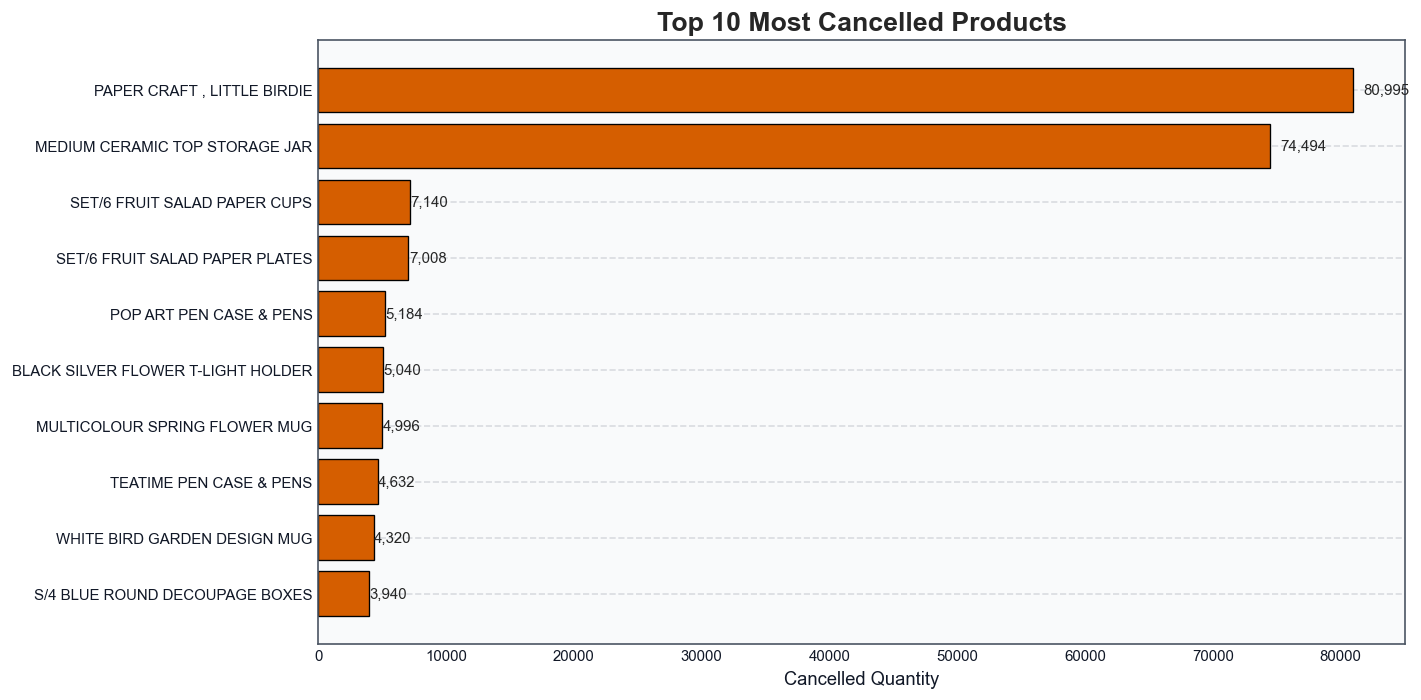

Products with Highest Cancellation-to-Sales Ratio


,Description,Sold,Cancelled,Cancel_Rate_%
2895,WHITE CHERRY LIGHTS,978.0,1072.0,109.61
251,BLACK CHERRY LIGHTS,242.0,248.0,102.48
1473,LITTLE FLOWER SHOPPER BAG,400.0,400.0,100.00
1783,"PAPER CRAFT , LITTLE BIRDIE",80995.0,80995.0,100.00
2063,RED POLKADOT PUDDING BOWL,3717.0,3648.0,98.14
335,BLUE POLKADOT PUDDING BOWL,2565.0,2496.0,97.31
1639,MULTICOLOUR POLKADOT PLATE,713.0,684.0,95.93
1545,MEDIUM CERAMIC TOP STORAGE JAR,78033.0,74494.0,95.46
2241,ROSES ON BLUE TEACUP CANDLE,539.0,504.0,93.51
2399,SET OF 6 DOTS CHOPSTICKS,211.0,181.0,85.78


In [62]:
# ============================================================
# Top 10 Cancelled Products (cleaned)
# ============================================================

exclude_keywords = ['manual', 'bank charges', 'postage', 'discount', 'fee',
                    'adjust', 'commission', 'dotcom', 'cruk', 'amazon',
                    'debt', 'john', 'charges', 'found', 'lost', 'test',
                    'sample', 'damages', 'wrongly', 'given away', 'missing',
                    'check', 'ebay', 'unsaleable', 'destroyed', 'printing smudges', r'\?']

exclude_mask = ~df_sales['Description'].str.lower().str.contains('|'.join(exclude_keywords), na=False)
df_clean = df_sales[exclude_mask & (df_sales['Price'] > 0.06)]

cancel_qty = df_clean[df_clean['Is_Cancellation']].groupby('Description')['Quantity'].sum().abs()
sold_qty   = df_clean[~df_clean['Is_Cancellation']].groupby('Description')['Quantity'].sum()

cancel_profile = (pd.concat([cancel_qty.rename('Cancelled'), sold_qty.rename('Sold')], axis=1)
                  .fillna(0).reset_index())
cancel_profile['Cancel_Rate_%'] = np.where(
    cancel_profile['Sold'] > 0,
    100 * cancel_profile['Cancelled'] / cancel_profile['Sold'], np.nan
)

top10 = cancel_profile.nlargest(10, 'Cancelled').copy()

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(top10['Description'].apply(lambda x: textwrap.shorten(x, width=42, placeholder='...')),
               top10['Cancelled'], color='#D55E00', edgecolor='black', linewidth=0.8)
for bar in bars:
    ax.text(bar.get_width() * 1.01, bar.get_y() + bar.get_height()/2,
            f'{int(bar.get_width()):,}', va='center', fontsize=9)
ax.set_title('Top 10 Most Cancelled Products', fontsize=16, fontweight='bold')
ax.set_xlabel('Cancelled Quantity')
ax.invert_yaxis()
ax.grid(axis='x')
plt.tight_layout()
plt.show()

# High cancellation-to-sales ratio (min 100 units sold)
high_ratio = (cancel_profile[cancel_profile['Sold'] >= 100]
              .nlargest(10, 'Cancel_Rate_%')
              [['Description', 'Sold', 'Cancelled', 'Cancel_Rate_%']])
print('Products with Highest Cancellation-to-Sales Ratio')
display(high_ratio.round(2))

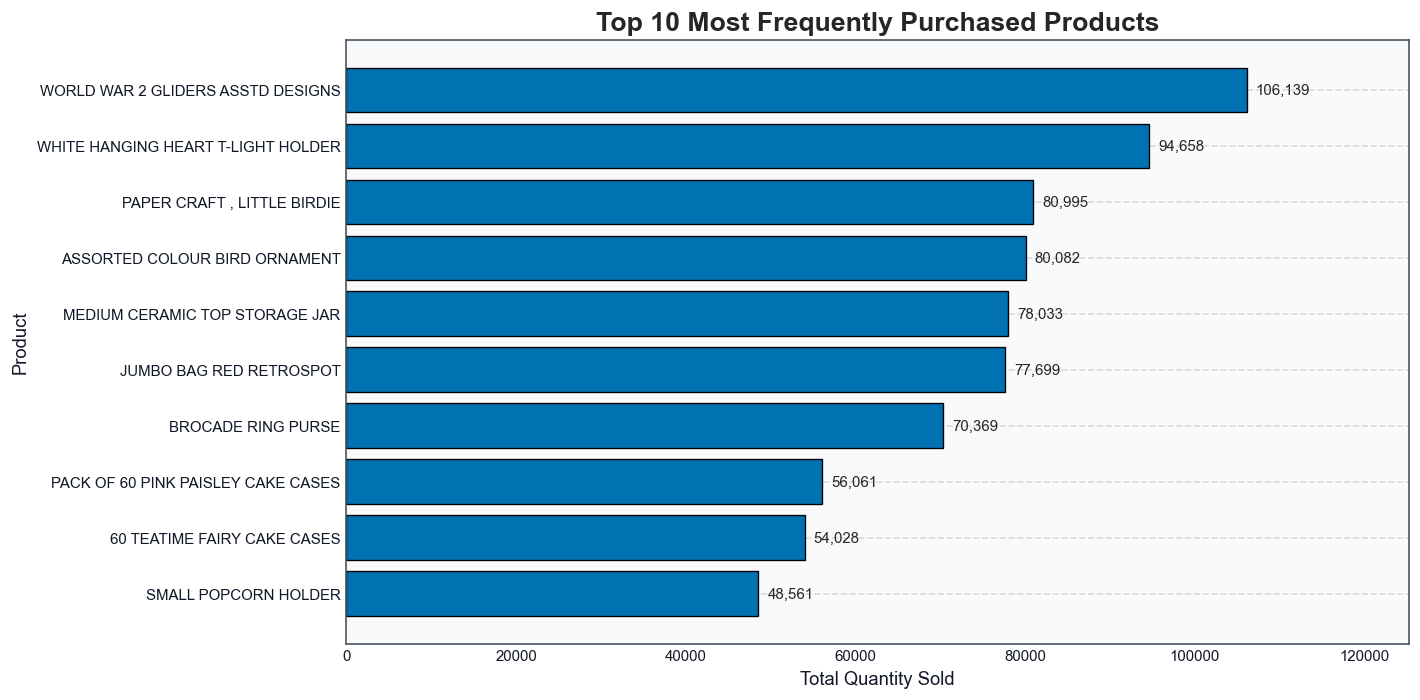

Top 10 products account for 6.66% of total unit volume


,Description,Total_Quantity_Sold,Total_Revenue,Quantity_Share_%
0,WORLD WAR 2 GLIDERS ASSTD DESIGNS,106139,"GBP 24,445.61",0.95
1,WHITE HANGING HEART T-LIGHT HOLDER,94658,"GBP 260,990.22",0.84
2,"PAPER CRAFT , LITTLE BIRDIE",80995,"GBP 168,469.60",0.72
3,ASSORTED COLOUR BIRD ORNAMENT,80082,"GBP 129,324.49",0.71
4,MEDIUM CERAMIC TOP STORAGE JAR,78033,"GBP 81,700.92",0.70
5,JUMBO BAG RED RETROSPOT,77699,"GBP 148,073.47",0.69
6,BROCADE RING PURSE,70369,"GBP 14,766.42",0.63
7,PACK OF 60 PINK PAISLEY CAKE CASES,56061,"GBP 28,081.73",0.50
8,60 TEATIME FAIRY CAKE CASES,54028,"GBP 27,041.21",0.48
9,SMALL POPCORN HOLDER,48561,"GBP 42,699.89",0.43


In [63]:
# ============================================================
# Top products by quantity and concentration
# ============================================================

product_perf = (df_sales[(df_sales['Quantity'] > 0) & (df_sales['Price'] > 0)]
                .groupby('Description')
                .agg(Total_Quantity_Sold=('Quantity', 'sum'),
                     Total_Revenue=('LineRevenue', 'sum'))
                .sort_values('Total_Quantity_Sold', ascending=False)
                .reset_index())

product_perf['Quantity_Share_%'] = 100 * product_perf['Total_Quantity_Sold'] / product_perf['Total_Quantity_Sold'].sum()
product_perf['Cumulative_Quantity_Share_%'] = product_perf['Quantity_Share_%'].cumsum()

top10_products = product_perf.head(10).copy()
top10_products['Product_Short'] = top10_products['Description'].apply(
    lambda x: textwrap.shorten(str(x), width=42, placeholder='...')
)

data = top10_products.iloc[::-1]

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(data['Product_Short'],
               data['Total_Quantity_Sold'],
               color='#0072B2', edgecolor='black', linewidth=0.8)

xmax = data['Total_Quantity_Sold'].max()
offset = max(1, xmax * 0.01)
for bar in bars:
    ax.text(bar.get_width() + offset, bar.get_y() + bar.get_height() / 2,
            f'{int(bar.get_width()):,}', va='center', fontsize=9)

ax.set_title('Top 10 Most Frequently Purchased Products', fontsize=16, fontweight='bold')
ax.set_xlabel('Total Quantity Sold')
ax.set_ylabel('Product')
ax.set_xlim(0, xmax * 1.18)
ax.grid(axis='x')
plt.tight_layout()
plt.show()

top10_share = top10_products['Quantity_Share_%'].sum()
print(f"Top 10 products account for {top10_share:.2f}% of total unit volume")

top10_display = top10_products[['Description', 'Total_Quantity_Sold', 'Total_Revenue', 'Quantity_Share_%']].copy()
top10_display['Total_Revenue'] = top10_display['Total_Revenue'].map(lambda x: format_gbp(x, 2))
display(top10_display.round({'Quantity_Share_%': 2}))


### Country Analysis

Goal: separate market scale from market quality using unique buyers, cancellation rate, and revenue together.


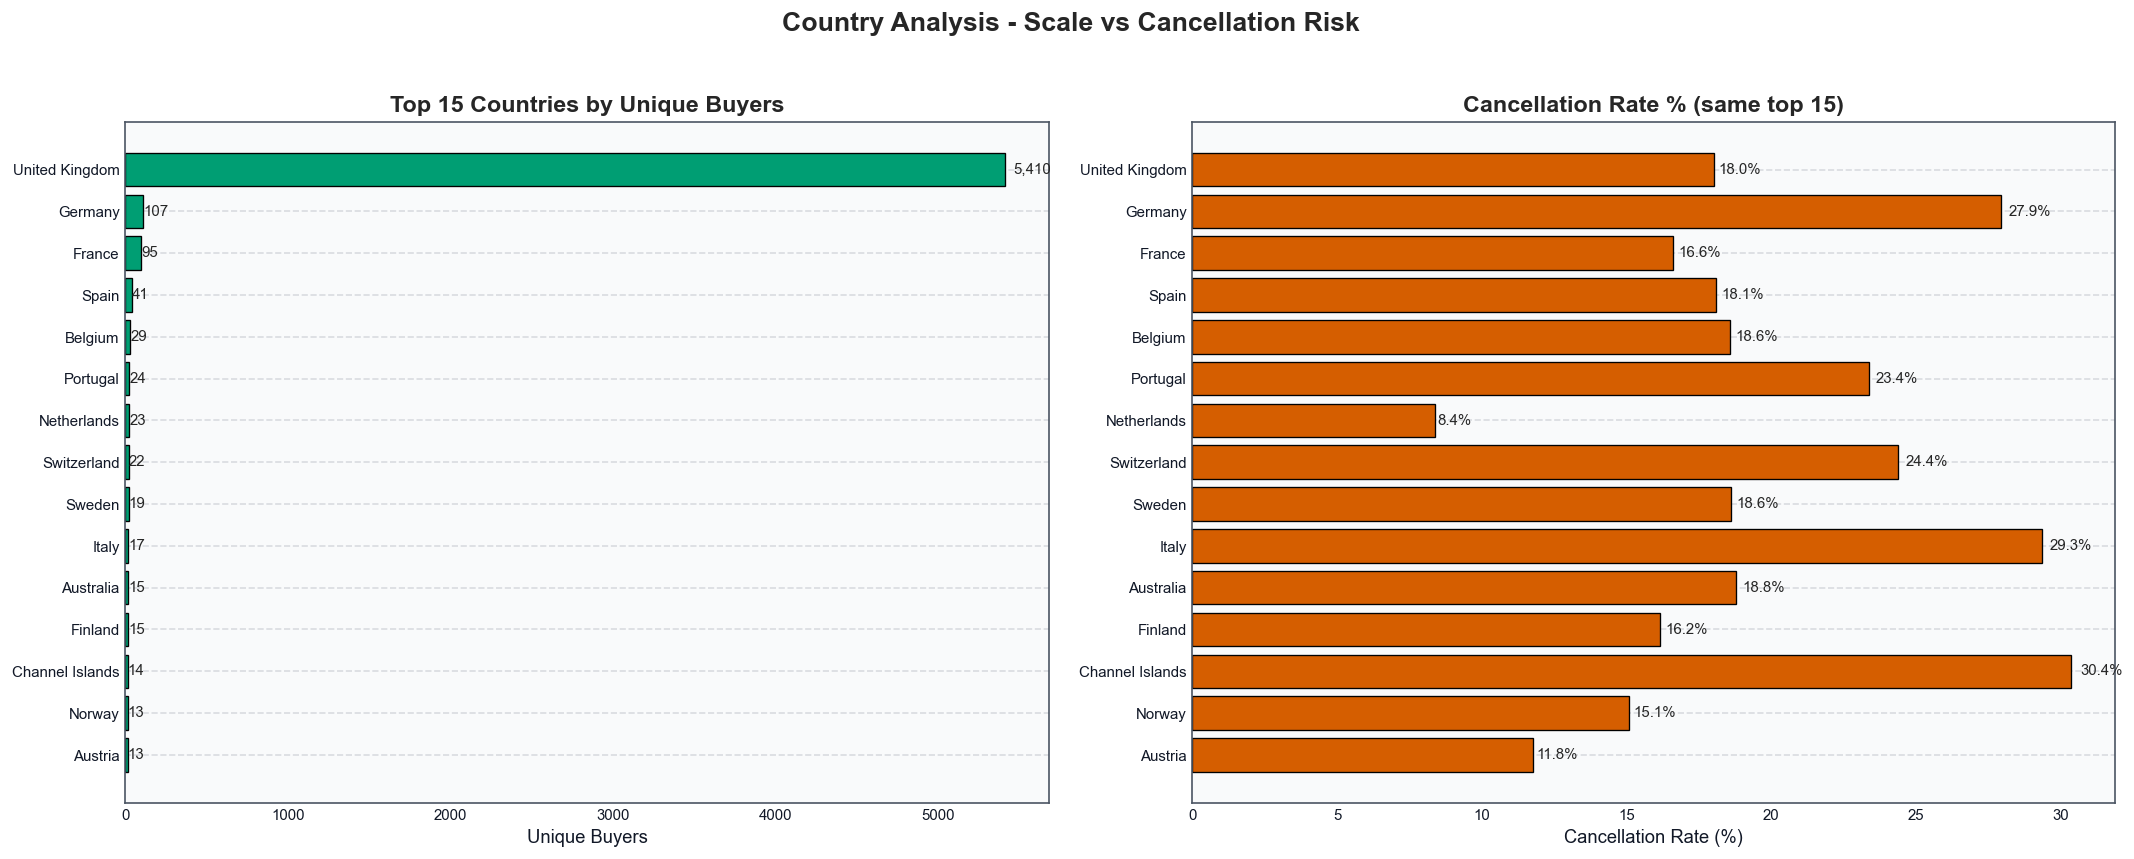

,Country,Unique_Buyers,Orders,Cancellation_Rate_%,Revenue
1,Austria,13,51,11.76,2.361301e+04
28,Norway,13,53,15.09,5.632250e+04
7,Channel Islands,14,79,30.38,4.462333e+04
13,Finland,15,68,16.18,2.992554e+04
0,Australia,15,117,18.80,1.692835e+05
20,Italy,17,92,29.35,3.210817e+04
35,Sweden,19,129,18.60,9.186982e+04
36,Switzerland,22,123,24.39,1.006856e+05
26,Netherlands,23,250,8.40,5.540381e+05
30,Portugal,24,124,23.39,5.628353e+04


In [64]:
# ============================================================
# Country Analysis - Scale vs Cancellation Risk
# ============================================================

country_metrics = df_sales.groupby('Country').agg(
    Unique_Buyers        = ('Customer ID', lambda x: x[x != 'Guest'].nunique()),
    Orders               = ('Invoice', 'nunique'),
    Revenue              = ('LineRevenue', lambda x: x[x > 0].sum()),
    Cancellation_Invoices= ('Invoice', lambda x: x[df_sales.loc[x.index, 'Is_Cancellation']].nunique())
).reset_index()

country_metrics['Cancellation_Rate_%'] = (
    100 * country_metrics['Cancellation_Invoices'] / country_metrics['Orders']
)

top15 = country_metrics.nlargest(15, 'Unique_Buyers').sort_values('Unique_Buyers')

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Buyers
bars = axes[0].barh(top15['Country'], top15['Unique_Buyers'], color='#009E73', edgecolor='black', linewidth=0.8)
for bar in bars:
    axes[0].text(bar.get_width() * 1.01, bar.get_y() + bar.get_height()/2,
                 f'{int(bar.get_width()):,}', va='center', fontsize=9)
axes[0].set_title('Top 15 Countries by Unique Buyers', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Unique Buyers')
axes[0].grid(axis='x')

# Cancellation Rate
bars = axes[1].barh(top15['Country'], top15['Cancellation_Rate_%'], color='#D55E00', edgecolor='black', linewidth=0.8)
for bar in bars:
    axes[1].text(bar.get_width() * 1.01, bar.get_y() + bar.get_height()/2,
                 f'{bar.get_width():.1f}%', va='center', fontsize=9)
axes[1].set_title('Cancellation Rate % (same top 15)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Cancellation Rate (%)')
axes[1].grid(axis='x')

plt.suptitle('Country Analysis - Scale vs Cancellation Risk', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

display(top15[['Country','Unique_Buyers','Orders','Cancellation_Rate_%','Revenue']].round({'Cancellation_Rate_%':2}))

---
## Customer Intelligence Models
---
### 1. RFM Segmentation

RFM is used as the primary behavioral segmentation layer, then linked to CLV and churn to build an action-ready customer strategy.


In [65]:
# ============================================================
# RFM Segmentation
# ============================================================

reference_date = df_customer['InvoiceDate'].max() + pd.Timedelta(days=1)

# Recency & Frequency — positive transactions only
rfm_base = df_customer[(df_customer['Quantity'] > 0) & (df_customer['Price'] > 0)]

rfm_rf = rfm_base.groupby('Customer ID').agg(
    Recency   = ('InvoiceDate', lambda x: (reference_date - x.max()).days),
    Frequency = ('Invoice', 'nunique')
).reset_index()

# Monetary — net revenue (cancellations auto net off)
rfm_m = (df_customer.groupby('Customer ID')['LineRevenue']
         .sum().reset_index(name='Monetary'))

rfm = rfm_rf.merge(rfm_m, on='Customer ID')

# Remove negative monetary (net returners — not useful for segmentation)
rfm = rfm[rfm['Monetary'] > 0].reset_index(drop=True)

# Scores
rfm['R_Score'] = pd.qcut(rfm['Recency'],                        q=5, labels=[5,4,3,2,1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=5, labels=[1,2,3,4,5]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'),  q=5, labels=[1,2,3,4,5]).astype(int)
rfm['RFM_Score'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']

# Segmentation
def segment(row):
    r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
    if r >= 4 and f >= 4 and m >= 4:   return 'Champion'
    elif r >= 3 and f >= 3 and m >= 3: return 'Loyal Customer'
    elif r >= 4 and f <= 2:            return 'New Customer'
    elif r >= 3 and f <= 2:            return 'Promising'
    elif r <= 2 and f >= 3:            return 'At Risk'
    elif r <= 2 and f <= 2 and m <= 2: return 'Lost'
    else:                              return 'Needs Attention'

rfm['Segment'] = rfm.apply(segment, axis=1)

# Net Revenue column for reference
rfm['Net_Revenue'] = rfm['Monetary']

print(f'Customers segmented: {len(rfm):,}')
print('\nSegment Distribution:')
display(rfm['Segment'].value_counts().reset_index())
display(rfm.head(10))

Customers segmented: 5,843

Segment Distribution:


,Segment,count
0,Champion,1295
1,Lost,1277
2,Loyal Customer,1122
3,At Risk,816
4,Needs Attention,515
5,New Customer,446
6,Promising,372


,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment,Net_Revenue
0,12347,2,8,4921.53,5,4,5,14,Champion,4921.53
1,12348,75,5,2019.40,3,4,4,11,Loyal Customer,2019.40
2,12349,19,4,4404.54,5,3,5,13,Loyal Customer,4404.54
3,12350,310,1,334.40,2,1,2,5,Lost,334.40
4,12351,375,1,300.93,2,1,2,5,Lost,300.93
5,12352,36,10,1889.21,4,5,4,13,Champion,1889.21
6,12353,204,2,406.76,2,2,2,6,Lost,406.76
7,12354,232,1,1079.40,2,1,3,6,Needs Attention,1079.40
8,12355,214,2,947.61,2,2,3,7,Needs Attention,947.61
9,12356,23,6,6371.73,4,4,5,13,Champion,6371.73


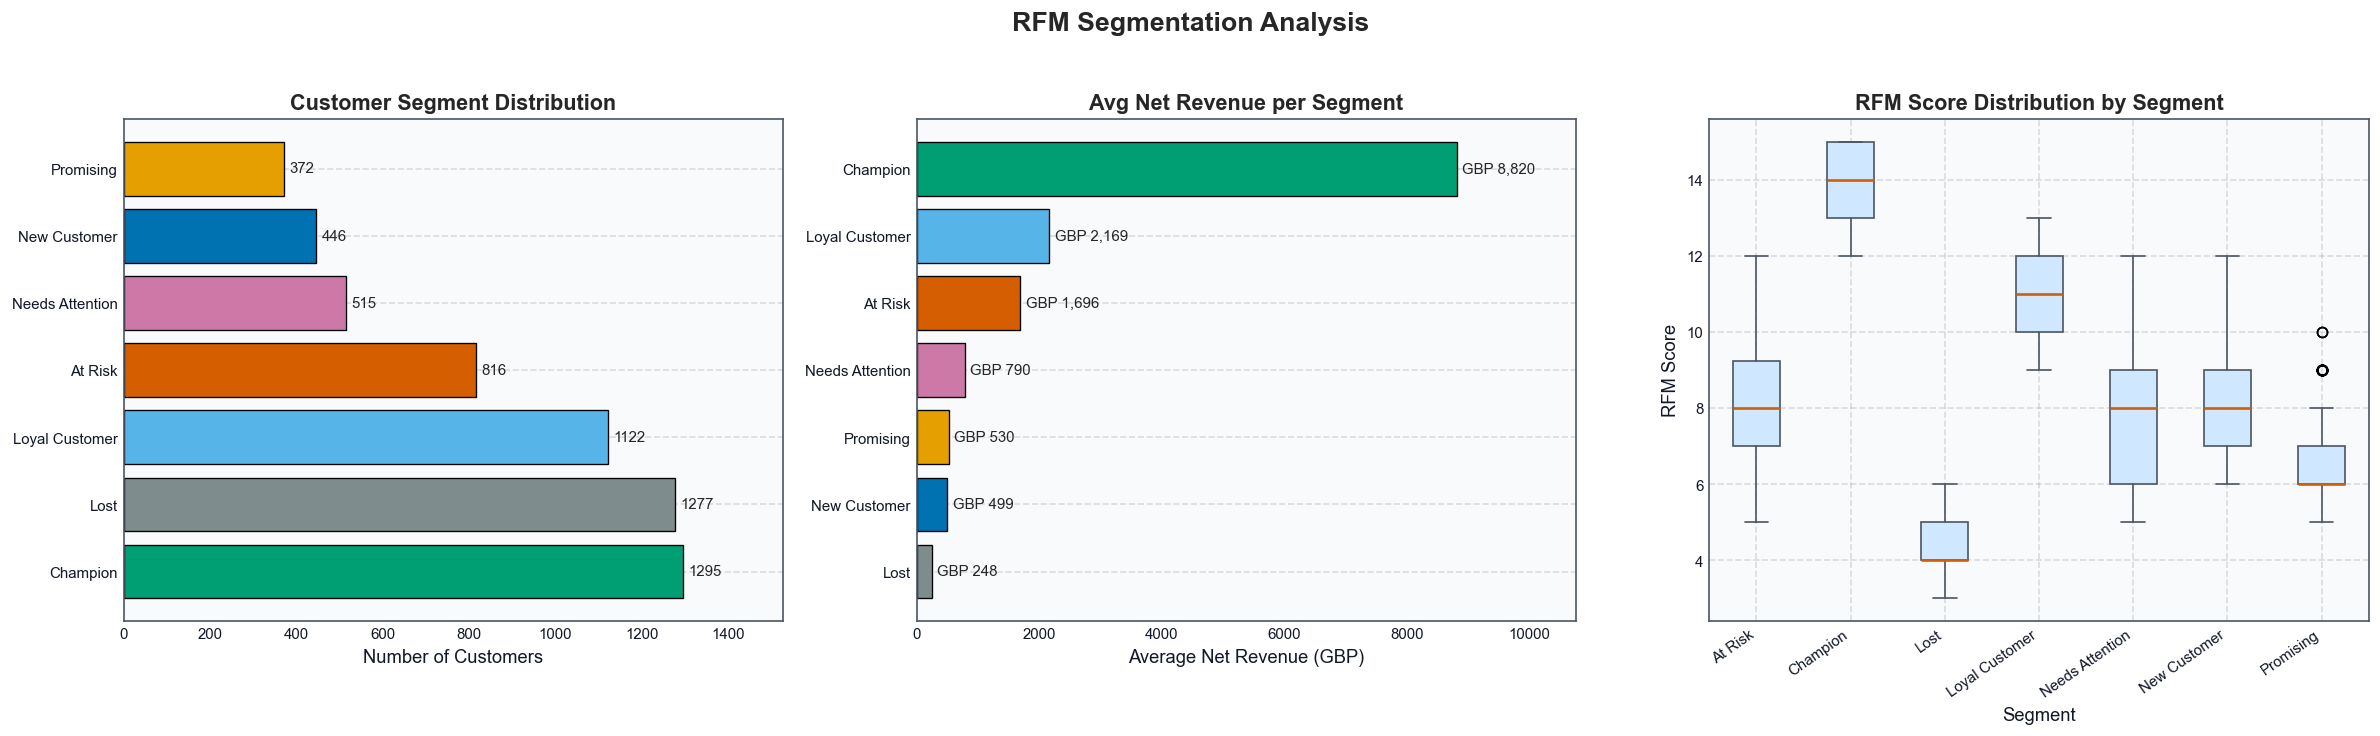

,Customer_Count,Avg_Recency_Days,Avg_Frequency,Avg_Net_Revenue,Total_Net_Revenue,Customer_Share_%,Revenue_Share_%
Segment,,,,,,,
Champion,1295,19.92,17.12,"GBP 8,820.19","GBP 11,422,142",22.16,69.72
Loyal Customer,1122,72.89,5.98,"GBP 2,169.30","GBP 2,433,955",19.2,14.86
At Risk,816,365.64,4.99,"GBP 1,695.97","GBP 1,383,913",13.97,8.45
Needs Attention,515,227.53,2.47,GBP 789.74,"GBP 406,714",8.81,2.48
Lost,1277,465.34,1.19,GBP 247.58,"GBP 316,164",21.86,1.93
New Customer,446,28.15,1.46,GBP 499.43,"GBP 222,746",7.63,1.36
Promising,372,105.61,1.37,GBP 529.55,"GBP 196,993",6.37,1.20


In [66]:
# ============================================================
# RFM Visualizations
# ============================================================

segment_colors = {
    'Champion': '#009E73',
    'Loyal Customer': '#56B4E9',
    'New Customer': '#0072B2',
    'Promising': '#E69F00',
    'At Risk': '#D55E00',
    'Needs Attention': '#CC79A7',
    'Lost': '#7f8c8d'
}

seg_counts = rfm['Segment'].value_counts().reset_index()
seg_counts.columns = ['Segment', 'Count']

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Segment Distribution
colors = [segment_colors[s] for s in seg_counts['Segment']]
bars_seg = axes[0].barh(seg_counts['Segment'], seg_counts['Count'], color=colors, edgecolor='black', linewidth=0.8)
count_offset = max(1, seg_counts['Count'].max() * 0.01)
for bar in bars_seg:
    axes[0].text(bar.get_width() + count_offset,
                 bar.get_y() + bar.get_height() / 2,
                 f"{int(bar.get_width())}", va='center', fontsize=9)
axes[0].set_title('Customer Segment Distribution', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Number of Customers')
axes[0].set_xlim(0, seg_counts['Count'].max() * 1.18)
axes[0].grid(axis='x')

# Avg net revenue by segment
seg_monetary = rfm.groupby('Segment')['Net_Revenue'].mean().sort_values(ascending=True)
colors2 = [segment_colors[s] for s in seg_monetary.index]
bars_money = axes[1].barh(seg_monetary.index, seg_monetary.values, color=colors2, edgecolor='black', linewidth=0.8)
money_offset = max(5, seg_monetary.max() * 0.01)
for bar in bars_money:
    axes[1].text(bar.get_width() + money_offset,
                 bar.get_y() + bar.get_height() / 2,
                 format_gbp(bar.get_width()), va='center', fontsize=9)
axes[1].set_title('Avg Net Revenue per Segment', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Average Net Revenue (GBP)')
axes[1].set_xlim(0, seg_monetary.max() * 1.22)
axes[1].grid(axis='x')

# RFM score distribution
rfm.boxplot(column='RFM_Score', by='Segment', ax=axes[2], patch_artist=True,
            boxprops=dict(facecolor='#cfe8ff', color='#4b5563'),
            medianprops=dict(color='#D55E00', linewidth=1.6),
            whiskerprops=dict(color='#4b5563'),
            capprops=dict(color='#4b5563'))
axes[2].set_title('RFM Score Distribution by Segment', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Segment')
axes[2].set_ylabel('RFM Score')
axes[2].tick_params(axis='x', rotation=35)
for lbl in axes[2].get_xticklabels():
    lbl.set_ha('right')
fig.suptitle('')

plt.suptitle('RFM Segmentation Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Summary table for decision making
rfm_summary = rfm.groupby('Segment').agg(
    Customer_Count=('Customer ID', 'count'),
    Avg_Recency_Days=('Recency', 'mean'),
    Avg_Frequency=('Frequency', 'mean'),
    Avg_Net_Revenue=('Net_Revenue', 'mean'),
    Total_Net_Revenue=('Net_Revenue', 'sum')
).round(2)

rfm_summary['Customer_Share_%'] = 100 * rfm_summary['Customer_Count'] / rfm_summary['Customer_Count'].sum()
rfm_summary['Revenue_Share_%'] = 100 * rfm_summary['Total_Net_Revenue'] / rfm_summary['Total_Net_Revenue'].sum()
rfm_summary = rfm_summary.sort_values('Total_Net_Revenue', ascending=False)

rfm_summary_display = rfm_summary.copy()
rfm_summary_display['Avg_Net_Revenue'] = rfm_summary_display['Avg_Net_Revenue'].map(lambda x: format_gbp(x, 2))
rfm_summary_display['Total_Net_Revenue'] = rfm_summary_display['Total_Net_Revenue'].map(lambda x: format_gbp(x))

display(rfm_summary_display.round({'Customer_Share_%': 2, 'Revenue_Share_%': 2}))


### 2. Cohort Retention Analysis

This section tracks acquisition cohorts over time and includes a weighted portfolio-level retention curve so large cohorts are not visually diluted by small cohorts.


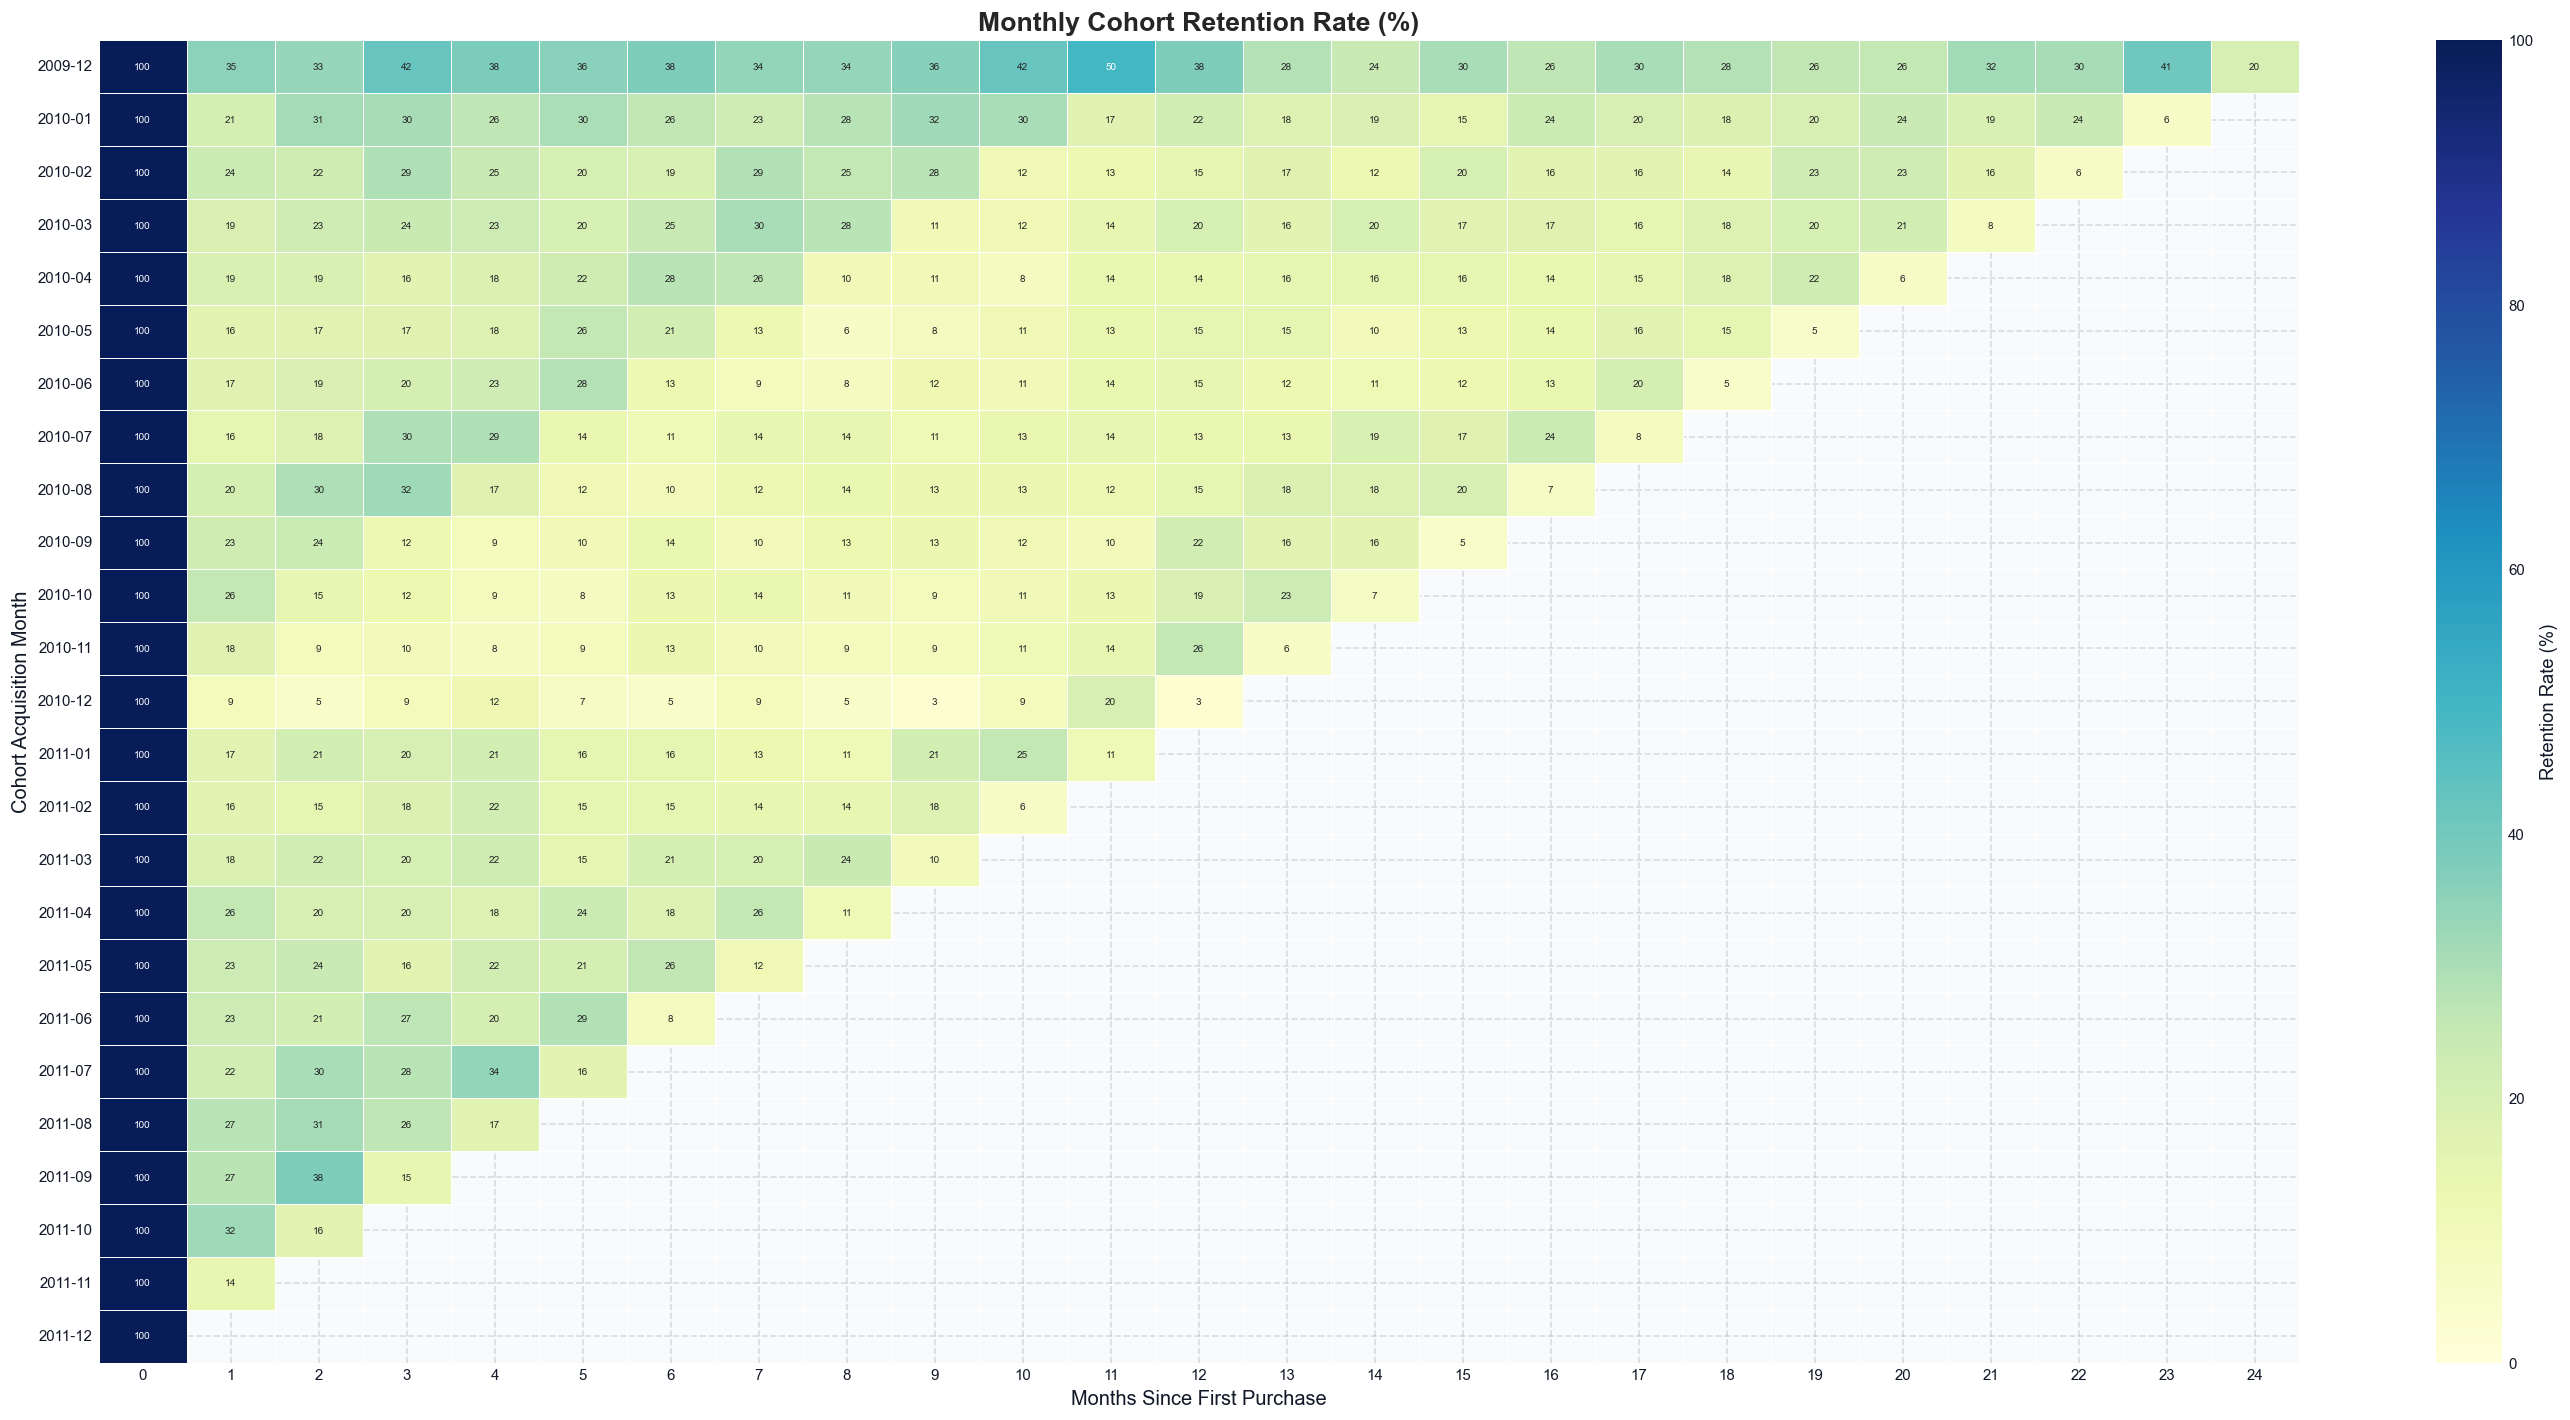

Heatmap annotations were hidden to avoid text overlap.
Weighted retention curve (portfolio-level view)


,Month_Since_Acquisition,Weighted_Retention_%
0,0,100.00
1,1,23.04
2,2,22.41
3,3,22.68
4,4,20.26
5,5,19.00
6,6,18.68
7,7,17.93
8,8,16.09
9,9,15.28


Weighted Month-1 Retention: 23.0%
Weighted Month-3 Retention: 22.7%
Weighted Month-6 Retention: 18.7%
Weighted Month-12 Retention: 16.5%


In [67]:
# ============================================================
# Cohort Retention Analysis
# ============================================================

cohort_base = df_customer[(df_customer['Quantity'] > 0) & (df_customer['Price'] > 0)].copy()
cohort_base['InvoiceMonth'] = cohort_base['InvoiceDate'].dt.to_period('M')

cohort_data = cohort_base.groupby('Customer ID')['InvoiceMonth'].min().reset_index()
cohort_data.columns = ['Customer ID', 'CohortMonth']

df_cohort = cohort_base.merge(cohort_data, on='Customer ID')

df_cohort['CohortIndex'] = (
    df_cohort['InvoiceMonth'].dt.start_time.dt.to_period('M').astype(int)
    - df_cohort['CohortMonth'].dt.start_time.dt.to_period('M').astype(int)
)

cohort_counts = (df_cohort.groupby(['CohortMonth', 'CohortIndex'])['Customer ID']
                 .nunique()
                 .reset_index())

cohort_pivot = cohort_counts.pivot_table(index='CohortMonth', columns='CohortIndex', values='Customer ID')
cohort_size = cohort_pivot[0]
retention_fraction = cohort_pivot.divide(cohort_size, axis=0)
retention_matrix = (retention_fraction * 100).round(1)

annotate_cells = retention_matrix.shape[0] <= 12 and retention_matrix.shape[1] <= 14

plt.figure(figsize=(24, 12))
sns.heatmap(retention_matrix,
            annot= True,
            fmt='.0f',
            cmap='YlGnBu',
            linewidths=0.35,
            linecolor='white',
            vmin=0,
            vmax=100,
            mask=retention_matrix.isna(),
            annot_kws={'size': 6},
            cbar_kws={'label': 'Retention Rate (%)'})
plt.title('Monthly Cohort Retention Rate (%)', fontsize=16, fontweight='bold')
plt.xlabel('Months Since First Purchase', fontsize=12)
plt.ylabel('Cohort Acquisition Month', fontsize=12)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

if not annotate_cells:
    print('Heatmap annotations were hidden to avoid text overlap.')

# Weighted retention curve (weights = cohort size)
weighted_retention = (retention_fraction.mul(cohort_size, axis=0).sum(axis=0) / cohort_size.sum()) * 100
weighted_retention = weighted_retention.dropna()

retention_report = pd.DataFrame({
    'Month_Since_Acquisition': weighted_retention.index.astype(int),
    'Weighted_Retention_%': weighted_retention.values
}).sort_values('Month_Since_Acquisition')

print('Weighted retention curve (portfolio-level view)')
display(retention_report.head(13).round(2))

for month in [1, 3, 6, 12]:
    if month in weighted_retention.index:
        print(f"Weighted Month-{month} Retention: {weighted_retention.loc[month]:.1f}%")


### 3. Customer Lifetime Value (CLV) Estimation

Approach used:
- One-time buyers: CLV defaults to realized revenue.
- Repeat buyers: annualized proxy based on order value and purchase cadence.
- Outlier handling is split intentionally:
  - `99th percentile cap` for CLV tiering/model stability.
  - `95th percentile clip` for chart readability only.


Active customers  : 3,466
Churned customers : 2,377
Note: Churned customer CLV projections are kept for historical reference but flagged.

Total Customers with Valid CLV: 5,843

CLV Tier Distribution:


,CLV_Tier,count
0,Low,3075
1,Medium,1937
2,High,548
3,Premium,283


,Customer ID,Total_Revenue,Total_Orders,Avg_Order_Value,Projected_CLV,CLV_Tier,Is_Active
0,12347,4921.53,8,615.19125,3909.984188,Medium,True
1,12348,2019.40,5,403.88000,1628.908287,Medium,True
2,12349,4404.54,4,1101.13500,2115.338289,Medium,True
3,12350,334.40,1,334.40000,334.400000,Low,False
4,12351,300.93,1,300.93000,300.930000,Low,False
5,12352,1889.21,10,188.92100,1743.273834,Medium,True
6,12353,406.76,2,203.38000,363.890686,Low,False
7,12354,1079.40,1,1079.40000,1079.400000,Medium,False
8,12355,947.61,2,473.80500,489.911686,Low,False
9,12356,6371.73,6,1061.95500,4833.086970,High,True


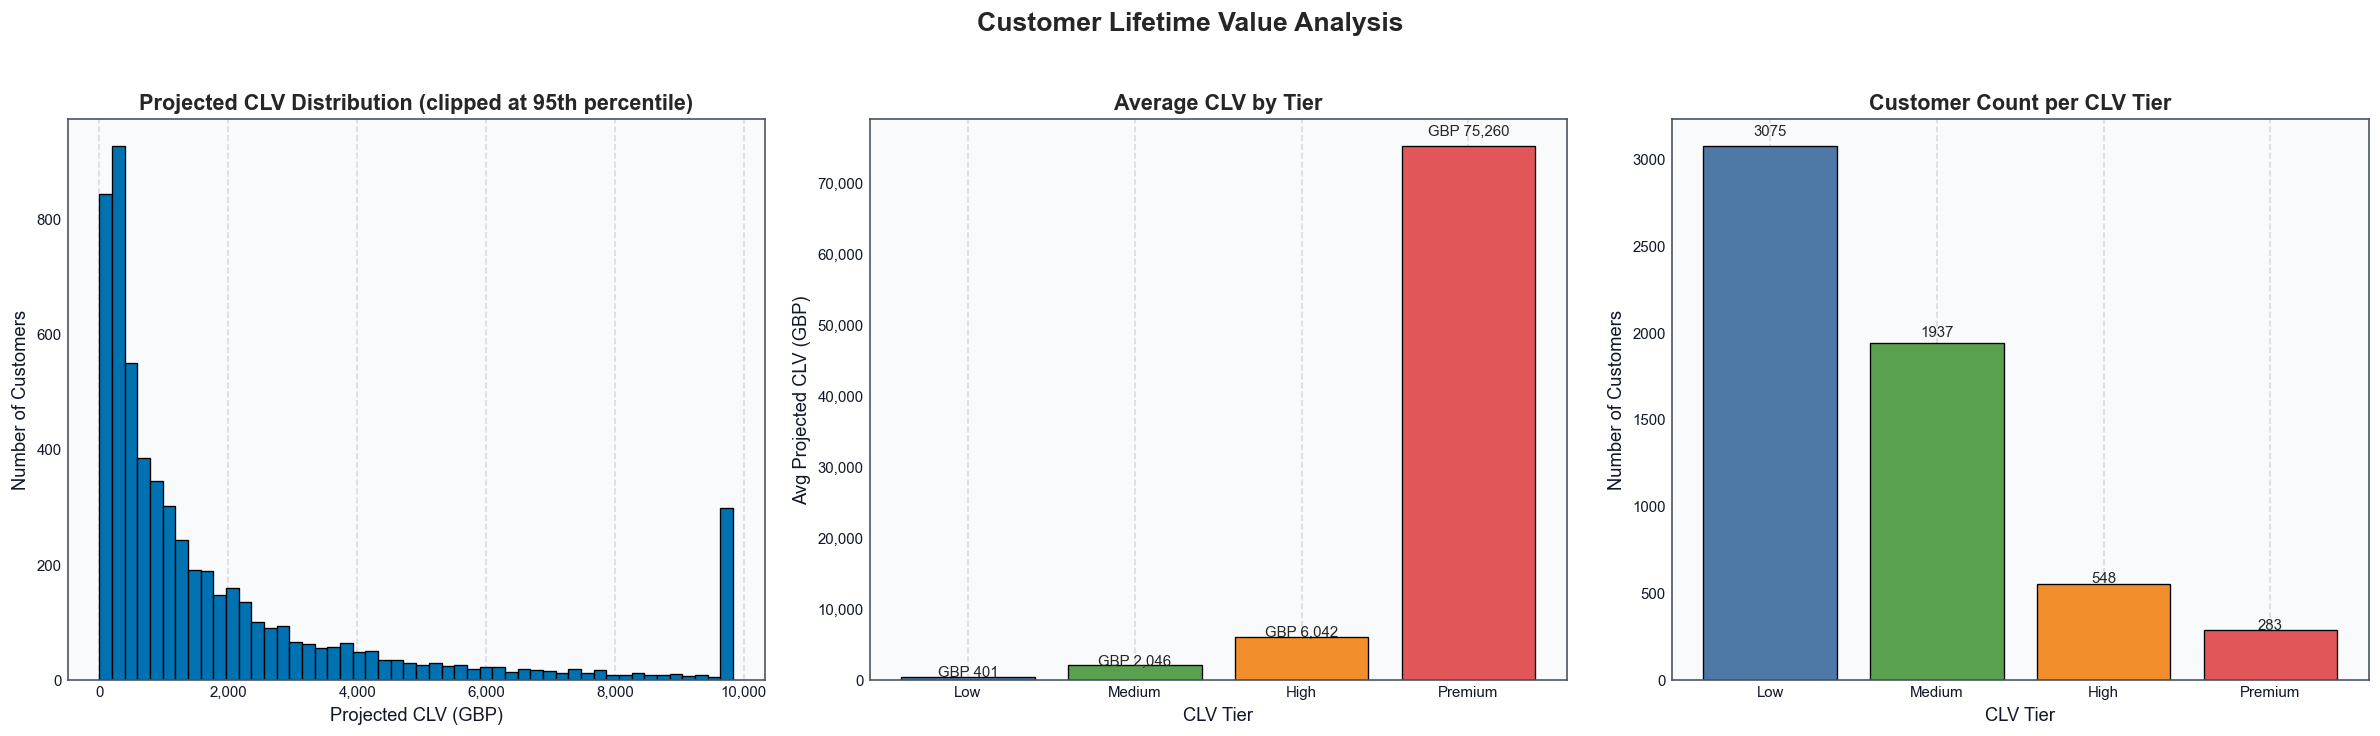

Top 10% customers contribute 78.75% of total CLV
Top 25% customers contribute 89.01% of total CLV


In [68]:
# ============================================================
# Customer Lifetime Value (CLV) estimation
# ============================================================

# Recency & Frequency base — positive transactions only
clv_rf = df_customer[(df_customer['Quantity'] > 0) & (df_customer['Price'] > 0)]

clv = clv_rf.groupby('Customer ID').agg(
    First_Purchase = ('InvoiceDate', 'min'),
    Last_Purchase  = ('InvoiceDate', 'max'),
    Total_Orders   = ('Invoice', 'nunique')
).reset_index()

# Monetary — net revenue (cancellations net off)
clv_m = df_customer.groupby('Customer ID')['LineRevenue'].sum().reset_index(name='Total_Revenue')
clv = clv.merge(clv_m, on='Customer ID')

# Remove negative net revenue customers
clv = clv[clv['Total_Revenue'] > 0].reset_index(drop=True)

clv['Lifespan_Days']   = (clv['Last_Purchase'] - clv['First_Purchase']).dt.days.clip(lower=1)
clv['Avg_Order_Value'] = clv['Total_Revenue'] / clv['Total_Orders']

clv['Avg_Days_Between'] = np.where(
    clv['Total_Orders'] > 1,
    clv['Lifespan_Days'] / (clv['Total_Orders'] - 1),
    np.nan
)

clv['Projected_CLV'] = np.where(
    clv['Total_Orders'] > 1,
    clv['Avg_Order_Value'] * (365 / clv['Avg_Days_Between']),
    clv['Total_Revenue']
)

# Flag churned customers (180-day threshold — consistent with churn proxy)
reference_date = df_customer['InvoiceDate'].max() + pd.Timedelta(days=1)
clv['Days_Since_Last_Purchase'] = (reference_date - clv['Last_Purchase']).dt.days
clv['Is_Active'] = clv['Days_Since_Last_Purchase'] < 180

print(f"Active customers  : {clv['Is_Active'].sum():,}")
print(f"Churned customers : {(~clv['Is_Active']).sum():,}")
print("Note: Churned customer CLV projections are kept for historical reference but flagged.")

# Domain-aware tiering (wholesale business)
clv['CLV_Tier'] = pd.cut(
    clv['Projected_CLV'],
    bins=[0, 1000, 4000, 10000, float('inf')],
    labels=['Low', 'Medium', 'High', 'Premium']
)

clv = clv[clv['CLV_Tier'].notna()].reset_index(drop=True)

print(f"\nTotal Customers with Valid CLV: {len(clv):,}")
print('\nCLV Tier Distribution:')
display(clv['CLV_Tier'].value_counts().reindex(['Low','Medium','High','Premium']).reset_index())
display(clv[['Customer ID','Total_Revenue','Total_Orders','Avg_Order_Value',
             'Projected_CLV','CLV_Tier','Is_Active']].head(10))

# ============================================================
# CLV Visualization
# ============================================================

tier_order  = ['Low', 'Medium', 'High', 'Premium']
tier_colors = ['#4E79A7', '#59A14F', '#F28E2B', '#E15759']

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Distribution
clv_clipped = clv['Projected_CLV'].clip(upper=clv['Projected_CLV'].quantile(0.95))
axes[0].hist(clv_clipped, bins=50, color='#0072B2', edgecolor='black', linewidth=0.8)
axes[0].set_title('Projected CLV Distribution (clipped at 95th percentile)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Projected CLV (GBP)')
axes[0].set_ylabel('Number of Customers')
axes[0].xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
axes[0].grid(axis='y')

# Avg CLV by Tier
tier_summary = clv.groupby('CLV_Tier')['Projected_CLV'].mean().reindex(tier_order).reset_index()
bars = axes[1].bar(tier_summary['CLV_Tier'].astype(str), tier_summary['Projected_CLV'],
                   color=tier_colors, edgecolor='black', linewidth=0.8)
for bar in bars:
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.02,
                 f'GBP {bar.get_height():,.0f}', ha='center', fontsize=9)
axes[1].set_title('Average CLV by Tier', fontsize=13, fontweight='bold')
axes[1].set_xlabel('CLV Tier')
axes[1].set_ylabel('Avg Projected CLV (GBP)')
axes[1].yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
axes[1].grid(axis='y')

# Customer Count per Tier
tier_counts = clv['CLV_Tier'].value_counts().reindex(tier_order).reset_index()
tier_counts.columns = ['CLV_Tier', 'Count']
bars_count = axes[2].bar(tier_counts['CLV_Tier'].astype(str), tier_counts['Count'],
                         color=tier_colors, edgecolor='black', linewidth=0.8)
for bar in bars_count:
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.02,
                 f'{int(bar.get_height())}', ha='center', fontsize=9)
axes[2].set_title('Customer Count per CLV Tier', fontsize=13, fontweight='bold')
axes[2].set_xlabel('CLV Tier')
axes[2].set_ylabel('Number of Customers')
axes[2].grid(axis='y')

plt.suptitle('Customer Lifetime Value Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Pareto concentration check
clv_sorted = clv.sort_values('Projected_CLV', ascending=False).reset_index(drop=True)
clv_sorted['Cumulative_CLV_Share_%'] = 100 * clv_sorted['Projected_CLV'].cumsum() / clv_sorted['Projected_CLV'].sum()

top_10 = max(1, int(np.ceil(len(clv_sorted) * 0.10)))
top_25 = max(1, int(np.ceil(len(clv_sorted) * 0.25)))

print(f"Top 10% customers contribute {clv_sorted.loc[top_10-1, 'Cumulative_CLV_Share_%']:.2f}% of total CLV")
print(f"Top 25% customers contribute {clv_sorted.loc[top_25-1, 'Cumulative_CLV_Share_%']:.2f}% of total CLV")

### RFM Segment vs CLV Tier - Cross Analysis

Purpose: validate whether behavioral segments (RFM) and monetary tiers (CLV) tell a coherent story or reveal misclassification opportunities.


RFM Segment vs CLV Cross Analysis


,Segment,Customer_Count,Avg_CLV,Median_CLV,Total_CLV,Customer_Share_%,CLV_Share_%
1,Champion,1295,"GBP 7,688.93","GBP 2,522.82","GBP 9,957,164",22.16,33.41
3,Loyal Customer,1122,"GBP 5,229.56","GBP 1,125.86","GBP 5,867,566",19.2,19.69
4,Needs Attention,515,"GBP 11,235.53",GBP 728.50,"GBP 5,786,298",8.81,19.41
0,At Risk,816,"GBP 5,809.05","GBP 1,363.83","GBP 4,740,185",13.97,15.90
2,Lost,1277,"GBP 1,252.98",GBP 229.75,"GBP 1,600,054",21.86,5.37
6,Promising,372,"GBP 2,671.31",GBP 344.41,"GBP 993,728",6.37,3.33
5,New Customer,446,"GBP 1,931.79",GBP 349.32,"GBP 861,579",7.63,2.89


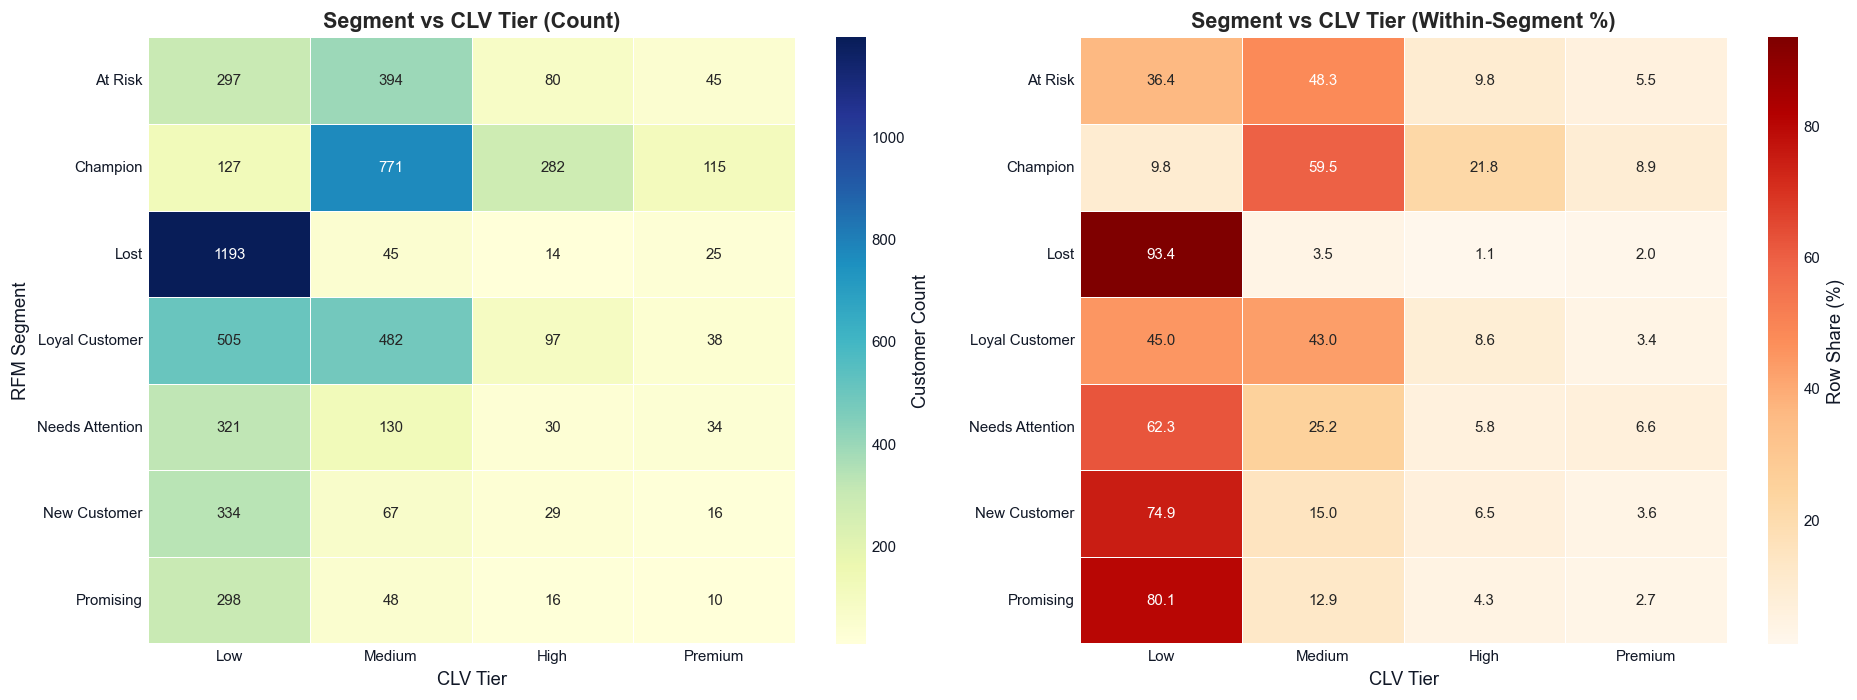

In [69]:
# ============================================================
# RFM Segment vs CLV Tier - Cross Analysis
# ============================================================

rfm_clv = rfm[['Customer ID', 'Segment', 'RFM_Score']].merge(
    clv[['Customer ID', 'Projected_CLV', 'CLV_Tier']],
    on='Customer ID', how='inner'
)

cross_summary = (rfm_clv.groupby('Segment')
                 .agg(Customer_Count=('Customer ID', 'count'),
                      Avg_CLV=('Projected_CLV', 'mean'),
                      Median_CLV=('Projected_CLV', 'median'),
                      Total_CLV=('Projected_CLV', 'sum'))
                 .reset_index())

cross_summary['Customer_Share_%'] = 100 * cross_summary['Customer_Count'] / cross_summary['Customer_Count'].sum()
cross_summary['CLV_Share_%'] = 100 * cross_summary['Total_CLV'] / cross_summary['Total_CLV'].sum()

cross_display = cross_summary.sort_values('Total_CLV', ascending=False).copy()
cross_display['Avg_CLV'] = cross_display['Avg_CLV'].map(lambda x: format_gbp(x, 2))
cross_display['Median_CLV'] = cross_display['Median_CLV'].map(lambda x: format_gbp(x, 2))
cross_display['Total_CLV'] = cross_display['Total_CLV'].map(lambda x: format_gbp(x))

print('RFM Segment vs CLV Cross Analysis')
display(cross_display.round({'Customer_Share_%': 2, 'CLV_Share_%': 2}))

pivot_count = rfm_clv.groupby(['Segment', 'CLV_Tier']).size().unstack(fill_value=0)
pivot_count = pivot_count.reindex(columns=['Low', 'Medium', 'High', 'Premium'])
pivot_row_pct = pivot_count.div(pivot_count.sum(axis=1), axis=0) * 100

fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 1]})

sns.heatmap(pivot_count,
            annot=True,
            fmt='d',
            cmap='YlGnBu',
            linewidths=0.4,
            linecolor='white',
            cbar_kws={'label': 'Customer Count'},
            annot_kws={'size': 9},
            ax=axes[0])
axes[0].set_title('Segment vs CLV Tier (Count)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('CLV Tier')
axes[0].set_ylabel('RFM Segment')
axes[0].tick_params(axis='x', rotation=0)
axes[0].tick_params(axis='y', rotation=0)

sns.heatmap(pivot_row_pct,
            annot=True,
            fmt='.1f',
            cmap='OrRd',
            linewidths=0.4,
            linecolor='white',
            cbar_kws={'label': 'Row Share (%)'},
            annot_kws={'size': 9},
            ax=axes[1])
axes[1].set_title('Segment vs CLV Tier (Within-Segment %)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('CLV Tier')
axes[1].set_ylabel('')
axes[1].tick_params(axis='x', rotation=0)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()


### 4. Repeat Purchase Modeling

This section estimates repeat depth (`P(2+)`, `P(3+)`, `P(5+)`) and purchase cadence distribution to support CRM timing and lifecycle campaign design.


Buyer Type Distribution:


Buyer_Type
Repeat      72.39
One-Time    27.61
Name: proportion, dtype: float64

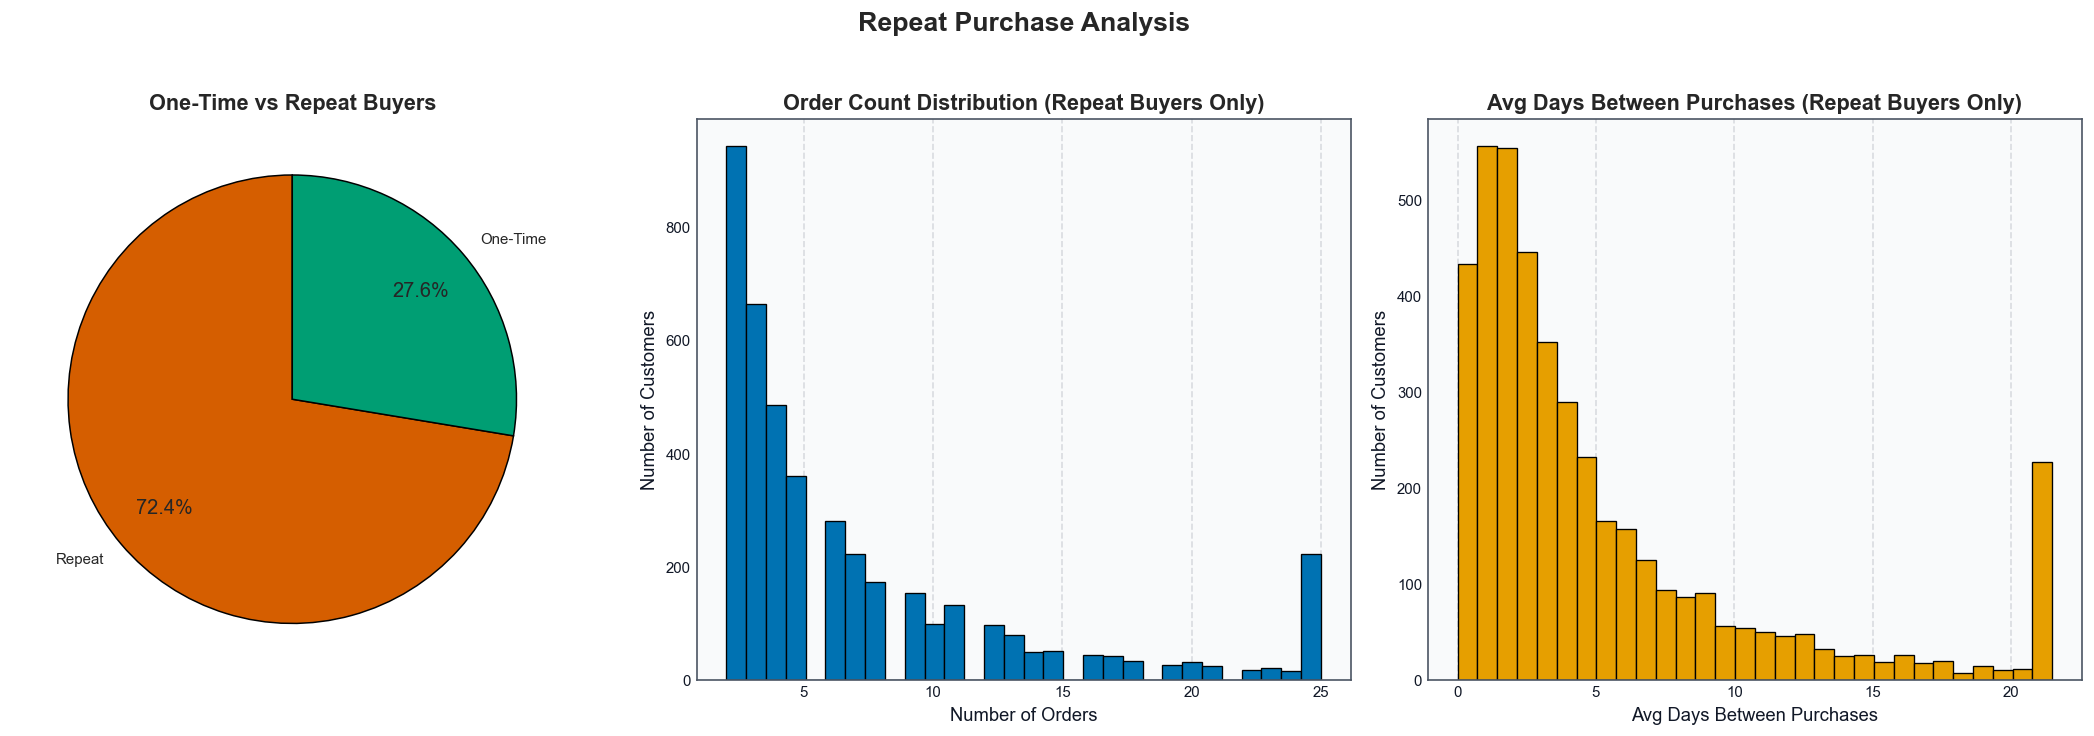

P(2+ orders): 72.39%
P(3+ orders): 56.33%
P(5+ orders): 36.76%
Median days between purchases (repeat buyers): 3.1
IQR days between purchases: 1.5 to 6.5


In [70]:
# ============================================================
# Repeat Purchase Modeling
# ============================================================

repeat_base = df_customer[(df_customer['Quantity'] > 0) & (df_customer['Price'] > 0)].copy()

purchase_counts = (repeat_base.groupby('Customer ID')['Invoice']
                   .nunique()
                   .reset_index(name='Order_Count'))

purchase_counts['Buyer_Type'] = np.where(purchase_counts['Order_Count'] == 1, 'One-Time', 'Repeat')

repeat_rate = purchase_counts['Buyer_Type'].value_counts(normalize=True) * 100
print('Buyer Type Distribution:')
display(repeat_rate.round(2))

df_sorted = repeat_base.sort_values(['Customer ID', 'InvoiceDate'])
df_sorted['Prev_Purchase'] = df_sorted.groupby('Customer ID')['InvoiceDate'].shift(1)
df_sorted['Days_Between'] = (df_sorted['InvoiceDate'] - df_sorted['Prev_Purchase']).dt.days

avg_days_between = (df_sorted.groupby('Customer ID')['Days_Between']
                    .mean()
                    .reset_index(name='Avg_Days_Between_Purchases'))

repeat_df = purchase_counts.merge(avg_days_between, on='Customer ID', how='left')
repeat_only = repeat_df[repeat_df['Buyer_Type'] == 'Repeat']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].pie(repeat_rate, labels=repeat_rate.index, autopct='%1.1f%%',
            colors=['#D55E00', '#009E73'], startangle=90,
            pctdistance=0.75,
            wedgeprops={'edgecolor': 'black', 'linewidth': 0.9})
axes[0].set_title('One-Time vs Repeat Buyers', fontsize=13, fontweight='bold')

axes[1].hist(repeat_only['Order_Count'].clip(upper=repeat_only['Order_Count'].quantile(0.95)),
             bins=30, color='#0072B2', edgecolor='black', linewidth=0.8)
axes[1].set_title('Order Count Distribution (Repeat Buyers Only)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Number of Orders')
axes[1].set_ylabel('Number of Customers')
axes[1].grid(axis='y')

axes[2].hist(repeat_only['Avg_Days_Between_Purchases'].dropna()
             .clip(upper=repeat_only['Avg_Days_Between_Purchases'].quantile(0.95)),
             bins=30, color='#E69F00', edgecolor='black', linewidth=0.8)
axes[2].set_title('Avg Days Between Purchases (Repeat Buyers Only)', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Avg Days Between Purchases')
axes[2].set_ylabel('Number of Customers')
axes[2].grid(axis='y')

plt.suptitle('Repeat Purchase Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

p_2plus = 100 * (purchase_counts['Order_Count'] >= 2).mean()
p_3plus = 100 * (purchase_counts['Order_Count'] >= 3).mean()
p_5plus = 100 * (purchase_counts['Order_Count'] >= 5).mean()

cadence_stats = repeat_only['Avg_Days_Between_Purchases'].describe(percentiles=[0.25, 0.5, 0.75])

print(f"P(2+ orders): {p_2plus:.2f}%")
print(f"P(3+ orders): {p_3plus:.2f}%")
print(f"P(5+ orders): {p_5plus:.2f}%")
print(f"Median days between purchases (repeat buyers): {cadence_stats['50%']:.1f}")
print(f"IQR days between purchases: {cadence_stats['25%']:.1f} to {cadence_stats['75%']:.1f}")


### 5. Churn Proxy Creation

Primary churn definition in this notebook: inactivity >= 90 days.
A sensitivity table is also included to show how churn rate changes under alternative thresholds.


Overall Churn Rate (180-day threshold): 40.7%


,Status,Count
0,Active,3466
1,Churned,2377


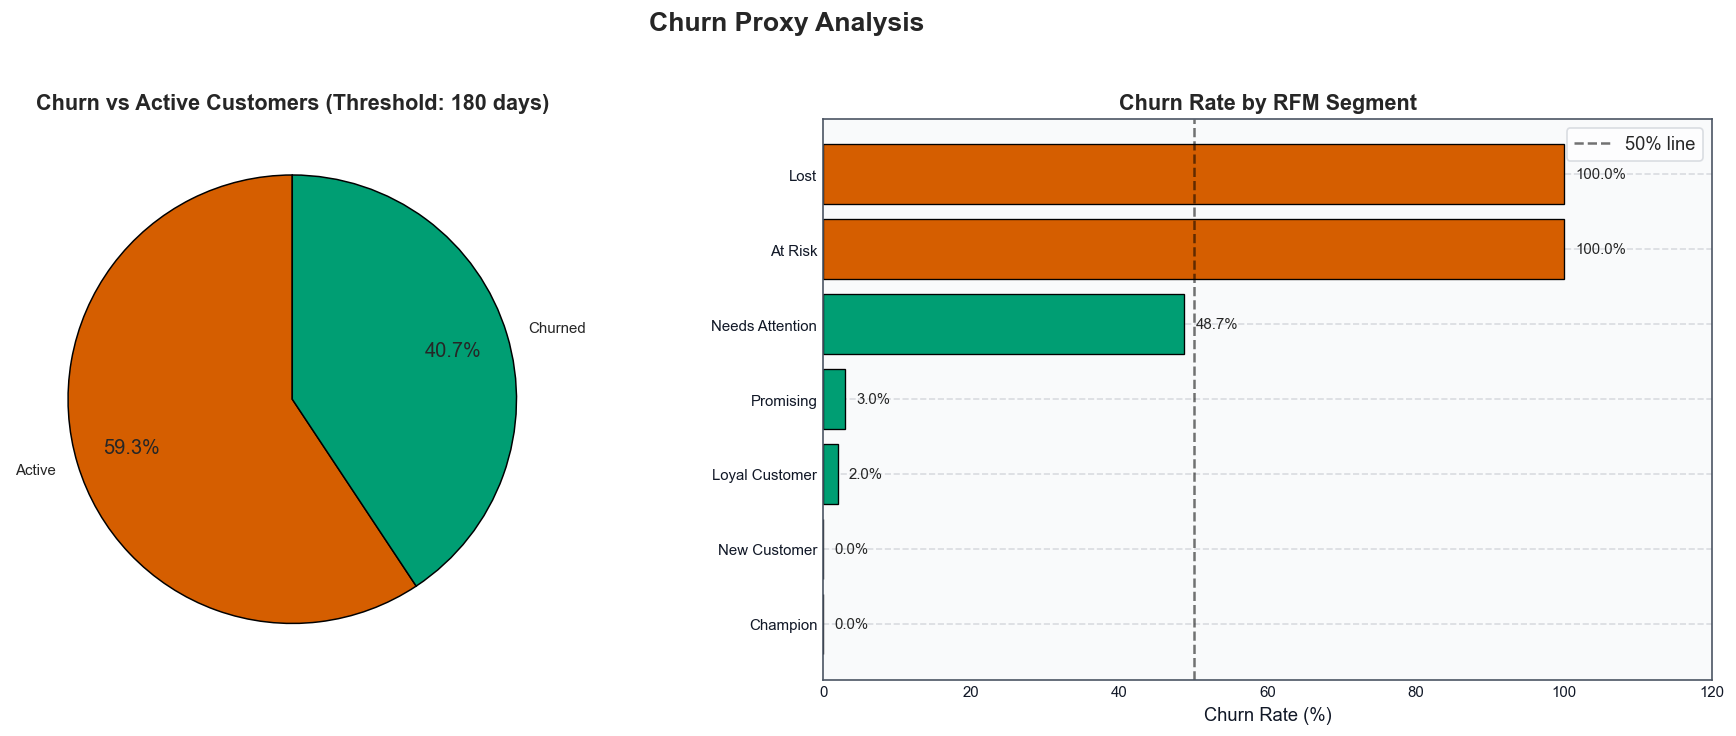

Churn-rate sensitivity to inactivity threshold


,Threshold_Days,Churn_Rate_%
0,90,50.81
1,120,46.86
2,150,43.78
3,180,40.68


Customers in early-warning zone (60 to 179 days inactive): 1,104


In [71]:
# ============================================================
# Churn Proxy Creation
# ============================================================

CHURN_THRESHOLD = 180

churn_df = rfm[['Customer ID', 'Recency', 'Segment']].copy()
churn_df['Churn_Flag'] = np.where(churn_df['Recency'] >= CHURN_THRESHOLD, 'Churned', 'Active')

churn_summary = churn_df['Churn_Flag'].value_counts().reset_index()
churn_summary.columns = ['Status', 'Count']
churn_rate = 100 * (churn_df['Churn_Flag'] == 'Churned').mean()

print(f"Overall Churn Rate ({CHURN_THRESHOLD}-day threshold): {churn_rate:.1f}%")
display(churn_summary)

churn_by_segment = (churn_df.groupby(['Segment', 'Churn_Flag'])
                    .size()
                    .unstack(fill_value=0)
                    .reset_index())
churn_by_segment['Churn_Rate_%'] = (
    churn_by_segment['Churned'] /
    (churn_by_segment['Churned'] + churn_by_segment['Active']) * 100
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].pie(churn_summary['Count'], labels=churn_summary['Status'],
            autopct='%1.1f%%', colors=['#D55E00', '#009E73'],
            startangle=90, pctdistance=0.75,
            wedgeprops={'edgecolor': 'black', 'linewidth': 0.9})
axes[0].set_title(f'Churn vs Active Customers (Threshold: {CHURN_THRESHOLD} days)',
                  fontsize=13, fontweight='bold')

churn_sorted = churn_by_segment.sort_values('Churn_Rate_%', ascending=True)
bar_colors = ['#009E73' if x < 50 else '#D55E00' for x in churn_sorted['Churn_Rate_%']]
bars = axes[1].barh(churn_sorted['Segment'], churn_sorted['Churn_Rate_%'],
                    color=bar_colors, edgecolor='black', linewidth=0.8)

rate_offset = max(0.3, churn_sorted['Churn_Rate_%'].max() * 0.015)
for bar in bars:
    axes[1].text(bar.get_width() + rate_offset,
                 bar.get_y() + bar.get_height() / 2,
                 f"{bar.get_width():.1f}%", va='center', fontsize=9)

axes[1].axvline(x=50, color='black', linestyle='--', alpha=0.55, label='50% line')
axes[1].set_title('Churn Rate by RFM Segment', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Churn Rate (%)')
axes[1].set_xlim(0, max(55, churn_sorted['Churn_Rate_%'].max() * 1.20))
axes[1].legend()
axes[1].grid(axis='x')

plt.suptitle('Churn Proxy Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Threshold sensitivity check
thresholds = [90, 120, 150, 180]
sensitivity = pd.DataFrame({
    'Threshold_Days': thresholds,
    'Churn_Rate_%': [100 * (churn_df['Recency'] >= t).mean() for t in thresholds]
})

print('Churn-rate sensitivity to inactivity threshold')
display(sensitivity.round(2))

soft_risk = churn_df[(churn_df['Recency'] >= 60) & (churn_df['Recency'] < CHURN_THRESHOLD)]
print(f"Customers in early-warning zone (60 to {CHURN_THRESHOLD - 1} days inactive): {len(soft_risk):,}")


_______________________________________________________________________________________
_______________________________________________________________________________________

# Observations, Conclusions & Strategic Action Plan

---

## EDA — Key Findings

**Revenue & AOV**
- Peak revenue month: `2011-11` at `GBP 1,456,146` — strong Q4 seasonality every year
- Average monthly revenue: `GBP 760,568` | Average AOV: `GBP 390.81`
- Revenue trend is growing year-on-year, driven by Q4 spikes — mid-year months are consistently weaker

**Demand Timing**
- Peak ordering hours: `10:00–15:00` on weekdays
- Thursday is the busiest day; Sunday is near-dead
- Weekday orders dominate — confirms B2B/wholesale buyer behaviour, not consumer retail

**Cancellations**
- Cancellation rows: `19,864` (`1.93%` of all transactions) — low overall rate
- Highest monthly cancellation rate: `22.55%` in `2010-05` — isolated spike, not structural
- Annual cancellation rate is stable — no worsening trend

**Products**
- Top 10 products account for only `6.66%` of total unit volume — demand is well distributed, no single product dominates
- Cancellation-to-sales ratio reveals specific products with structurally high return rates — worth monitoring separately

**Country**
- UK is the dominant market by buyers, revenue, and absolute cancellations
- International markets (Channel Islands, Italy, Germany) show disproportionately high cancellation rates (`25–30%`) relative   
  to their small buyer base — high operational cost, low return

---

## Customer Intelligence — Key Findings

### RFM Segmentation (`n = 5,843`)

| Segment | Customers | Share |
|---------|-----------|-------|
| Champion | 1,295 | 22.2% |
| Lost | 1,277 | 21.9% |
| Loyal Customer | 1,122 | 19.2% |
| At Risk | 816 | 14.0% |
| Needs Attention | 515 | 8.8% |
| New Customer | 446 | 7.6% |
| Promising | 372 | 6.4% |

- **Champions and Lost are almost equal in size** — for every best customer retained, one has been lost. Classic leaking bucket.
- At Risk (`816`) are former frequent buyers now going silent — highest urgency recovery group
- Needs Attention has the highest Avg CLV (`GBP 11,235`) despite mixed behaviour — contains high-spend irregular buyers worth investigating

---

### Cohort Retention

| Milestone | Weighted Retention |
|-----------|--------------------|
| Month 1 | 23.0% |
| Month 3 | 22.7% |
| Month 6 | 18.7% |
| Month 12 | 16.5% |

- **The biggest drop happens immediately after Month 0** — 77% of new customers do not return after their first purchase
- After Month 3, decay slows — customers who survive to Month 3 form a stable retained core
- Month 1 to Month 3 retention is nearly flat (`23.0% → 22.7%`) — survival past first purchase is the critical gate

---

### Customer Lifetime Value (`n = 5,843`)

| Tier | Customers | Avg CLV |
|------|-----------|---------|
| Low | 3,075 | ~GBP 300 |
| Medium | 1,937 | ~GBP 2,000 |
| High | 548 | ~GBP 5,500 |
| Premium | 283 | ~GBP 30,000+ |

- Top `10%` of customers contribute `78.75%` of total modelled CLV
- Top `25%` contribute `89.01%` — value is extremely concentrated
- `3,466` customers are active | `2,377` are churned (180-day threshold) — churned customer CLV projections are historical, not actionable
- Low tier dominates in count (`3,075`) but contributes minimally to total value

---

### RFM × CLV Cross Analysis

- **Champions:** `22.2%` of customers, `33.4%` of total CLV (`GBP 9.96M`) — highest revenue concentration
- **Loyal Customers:** `19.2%` of customers, `19.7%` of CLV — strong second tier
- **At Risk:** `14.0%` of customers but `15.9%` of CLV (`GBP 4.74M`) — commercially significant, urgent to recover
- **Lost:** `21.9%` of customers but only `5.4%` of CLV — confirms lost customers were mostly low-value; recovery ROI is low
- **Needs Attention:** high average CLV (`GBP 11,235`) driven by a few high-spend irregular buyers — worth profiling individually

---

### Repeat Purchase Analysis

- `P(2+)` = `72.39%` — nearly 3 in 4 customers place a second order
- `P(3+)` = `56.33%` — over half reach a third order
- `P(5+)` = `36.76%` — strong tail of loyal repeat buyers
- Median days between purchases: `3.1 days` | IQR: `1.5 – 6.5 days`
- The ultra-short cadence (`< 7 days`) confirms wholesale bulk ordering behaviour — not organic retail repurchase cycles
- One-time buyers (`27.6%`) represent the highest-leverage conversion opportunity

---

### Churn Proxy (180-day threshold)

| Threshold | Churn Rate |
|-----------|------------|
| 90 days | 50.81% |
| 120 days | 46.86% |
| 150 days | 43.78% |
| 180 days | 40.68% |

- At the domain-appropriate `180-day` threshold: **`40.7%` of customers are churned**
- `2,377` churned | `3,466` active
- `1,104` customers are in the **early-warning zone** (`60–179 days inactive`) — cheapest to recover before full churn
- Churn rate drops from `50.8%` to `40.7%` when moving from 90 to 180 days — the 90-day default would have overstated churn by `10 percentage points` for this wholesale business

---

## Strategic Recommendations (Priority Order)

**1. Fix the Month-0 to Month-1 drop-off (highest leverage)**
77% of new customers never return. A post-purchase sequence (email within 7 days, incentive on second order within 30 days) targeting this transition has the highest ROI of any action available.

**2. Protect Champions immediately**
Champions are `22%` of customers but `33%` of CLV. Any Champion inactive for `45+ days` should trigger proactive outreach. Losing even `10%` of Champions is a material revenue event.

**3. Recover At Risk before they become Lost**
`816` customers, `15.9%` of total CLV (`GBP 4.74M`) — these were frequent buyers now going silent. A time-sensitive win-back campaign before they cross the 180-day line is the most cost-effective recovery action.

**4. Convert the early-warning zone (`1,104` customers)**
These customers are `60–179 days` inactive — not yet churned but heading there. A targeted re-engagement campaign here is cheaper than recovering fully churned customers and the conversion rate will be higher.

**5. Push one-time buyers to a second purchase**
`27.6%` of customers placed only one order. A well-timed second-purchase incentive within `14 days` of first order is the single fastest way to lift repeat rate and P(2+).

**6. Investigate Needs Attention segment**
Average CLV of `GBP 11,235` is the highest of any segment — higher than Champions average. This segment likely contains high-spend irregular wholesale accounts. Profile them individually and assign account management.

**7. Deprioritise international markets with high cancellation rates**
Channel Islands, Italy, Germany show `25–30%` cancellation rates with small buyer bases. The operational cost of managing returns outweighs the revenue contribution. Consider minimum order requirements or revised returns policy for these markets.

---

## Limitations

- **22.8% of transactions have no `Customer ID`** — guest buyers are fully excluded from all customer-level models (RFM, CLV, churn, repeat). True repeat rate and CLV are likely understated.
- **CLV is a proxy, not a forecast** — the annualized projection assumes future purchase behaviour mirrors historical cadence. This assumption weakens for churned customers whose projections are optimistic.
- **Churn threshold is rule-based** — 180 days was chosen based on domain knowledge of wholesale buying cycles. A supervised churn model with labelled outcomes would be more reliable.
- **No acquisition cost data** — without marketing spend per customer, true profitability and payback period cannot be calculated. CLV alone does not indicate whether a customer was profitable to acquire.
- **No product category data** — all product analysis is at description level. Category-level concentration and cancellation analysis would require manual categorisation or an external product taxonomy.
